# Process Tail Simulation Results for tSNE

In [1]:
import os, pickle

results_dir = r"D:\2025-10-25 Limit RoR Cliff"

sample_file = "Cap (10M) - Ded (100K) - LR (0.6) - Pol_Lim (20M) - 100K Sims - 25 Yrs.pkl"

file_path = os.path.join(results_dir, sample_file)
with open(file_path, "rb") as f:
    loaded_sample_data = pickle.load(f)

In [2]:
loaded_sample_data

SimulationResults(final_assets=array([1.5992174e+07, 1.5693435e+07, 1.5760839e+07, ..., 1.5796749e+07,
       1.5622217e+07, 1.4950371e+07], shape=(100000,), dtype=float32), annual_losses=array([[3.6424659e+05, 1.2157663e+07, 4.5853878e+05, ..., 1.9256925e+05,
        4.5529075e+05, 1.5251696e+06],
       [2.5714353e+05, 2.7279534e+05, 3.1679434e+05, ..., 5.7431531e+05,
        3.8430788e+05, 4.1088362e+05],
       [5.1121520e+06, 1.3595953e+05, 1.5932463e+04, ..., 1.7533339e+06,
        2.7786200e+05, 6.1451325e+05],
       ...,
       [2.3832883e+05, 5.4496388e+05, 9.2889844e+05, ..., 1.3476975e+05,
        3.6384091e+05, 4.4522484e+05],
       [7.5004523e+04, 2.0995598e+05, 2.9172475e+05, ..., 3.4067845e+06,
        5.5312062e+05, 3.1048970e+06],
       [4.7880081e+05, 6.5439512e+05, 9.4558961e+04, ..., 1.5877359e+05,
        6.3157769e+05, 1.7728685e+06]], shape=(100000, 25), dtype=float32), insurance_recoveries=array([[0.00000000e+00, 1.17344530e+07, 1.69467547e+05, ...,
        0

In [15]:
loaded_sample_data.retained_losses.shape[1]

25

In [13]:
bankrupt_idxs = np.flatnonzero(loaded_sample_data.final_assets <= 10_000)
bankrupt_idxs

array([ 1739,  3576,  4699,  5157,  9392,  9647, 10251, 10468, 10920,
       11667, 16564, 16849, 16897, 18144, 18257, 19207, 19344, 23530,
       23871, 27335, 27797, 27978, 28063, 32727, 33052, 33728, 33741,
       34825, 36758, 37270, 37392, 40626, 40716, 43586, 44632, 48910,
       50467, 51954, 52826, 53345, 57908, 60517, 60533, 62221, 63117,
       64239, 65446, 66795, 66935, 69334, 70041, 71228, 74340, 75043,
       75113, 75422, 76517, 76531, 76593, 77734, 78207, 82229, 82420,
       84238, 84358, 86144, 86658, 88147, 88915, 89817, 91559, 91980,
       92647, 93276, 94583, 94585, 95492, 97439, 97738, 99551])

In [28]:
# Companies that went bankrupt have padded zeros in later years
n_years = 25
bankrupt_mask = []

for i in range(len(loaded_sample_data.annual_losses)):
    # Count consecutive zeros at the end
    non_zero_years = np.where(loaded_sample_data.annual_losses[i] != 0)[0]
    if len(non_zero_years) > 0:
        last_active_year = non_zero_years[-1]
        went_bankrupt = last_active_year < (n_years - 1)
    else:
        went_bankrupt = True  # No losses = immediate bankruptcy

    bankrupt_mask.append(went_bankrupt)

# Now filter
bankrupt_idxs = np.where(bankrupt_mask)[0]
# for idx in bankrupt_idxs:
#     print(f"Sim {idx}: Losses by year: {loaded_sample_data.annual_losses[idx]}")

print(f"Total bankruptcies detected (no annual losses): {len(bankrupt_idxs)}")
bankrupt_idxs[0:5]

Total bankruptcies detected (no annual losses): 2872


array([ 51,  89, 113, 143, 216])

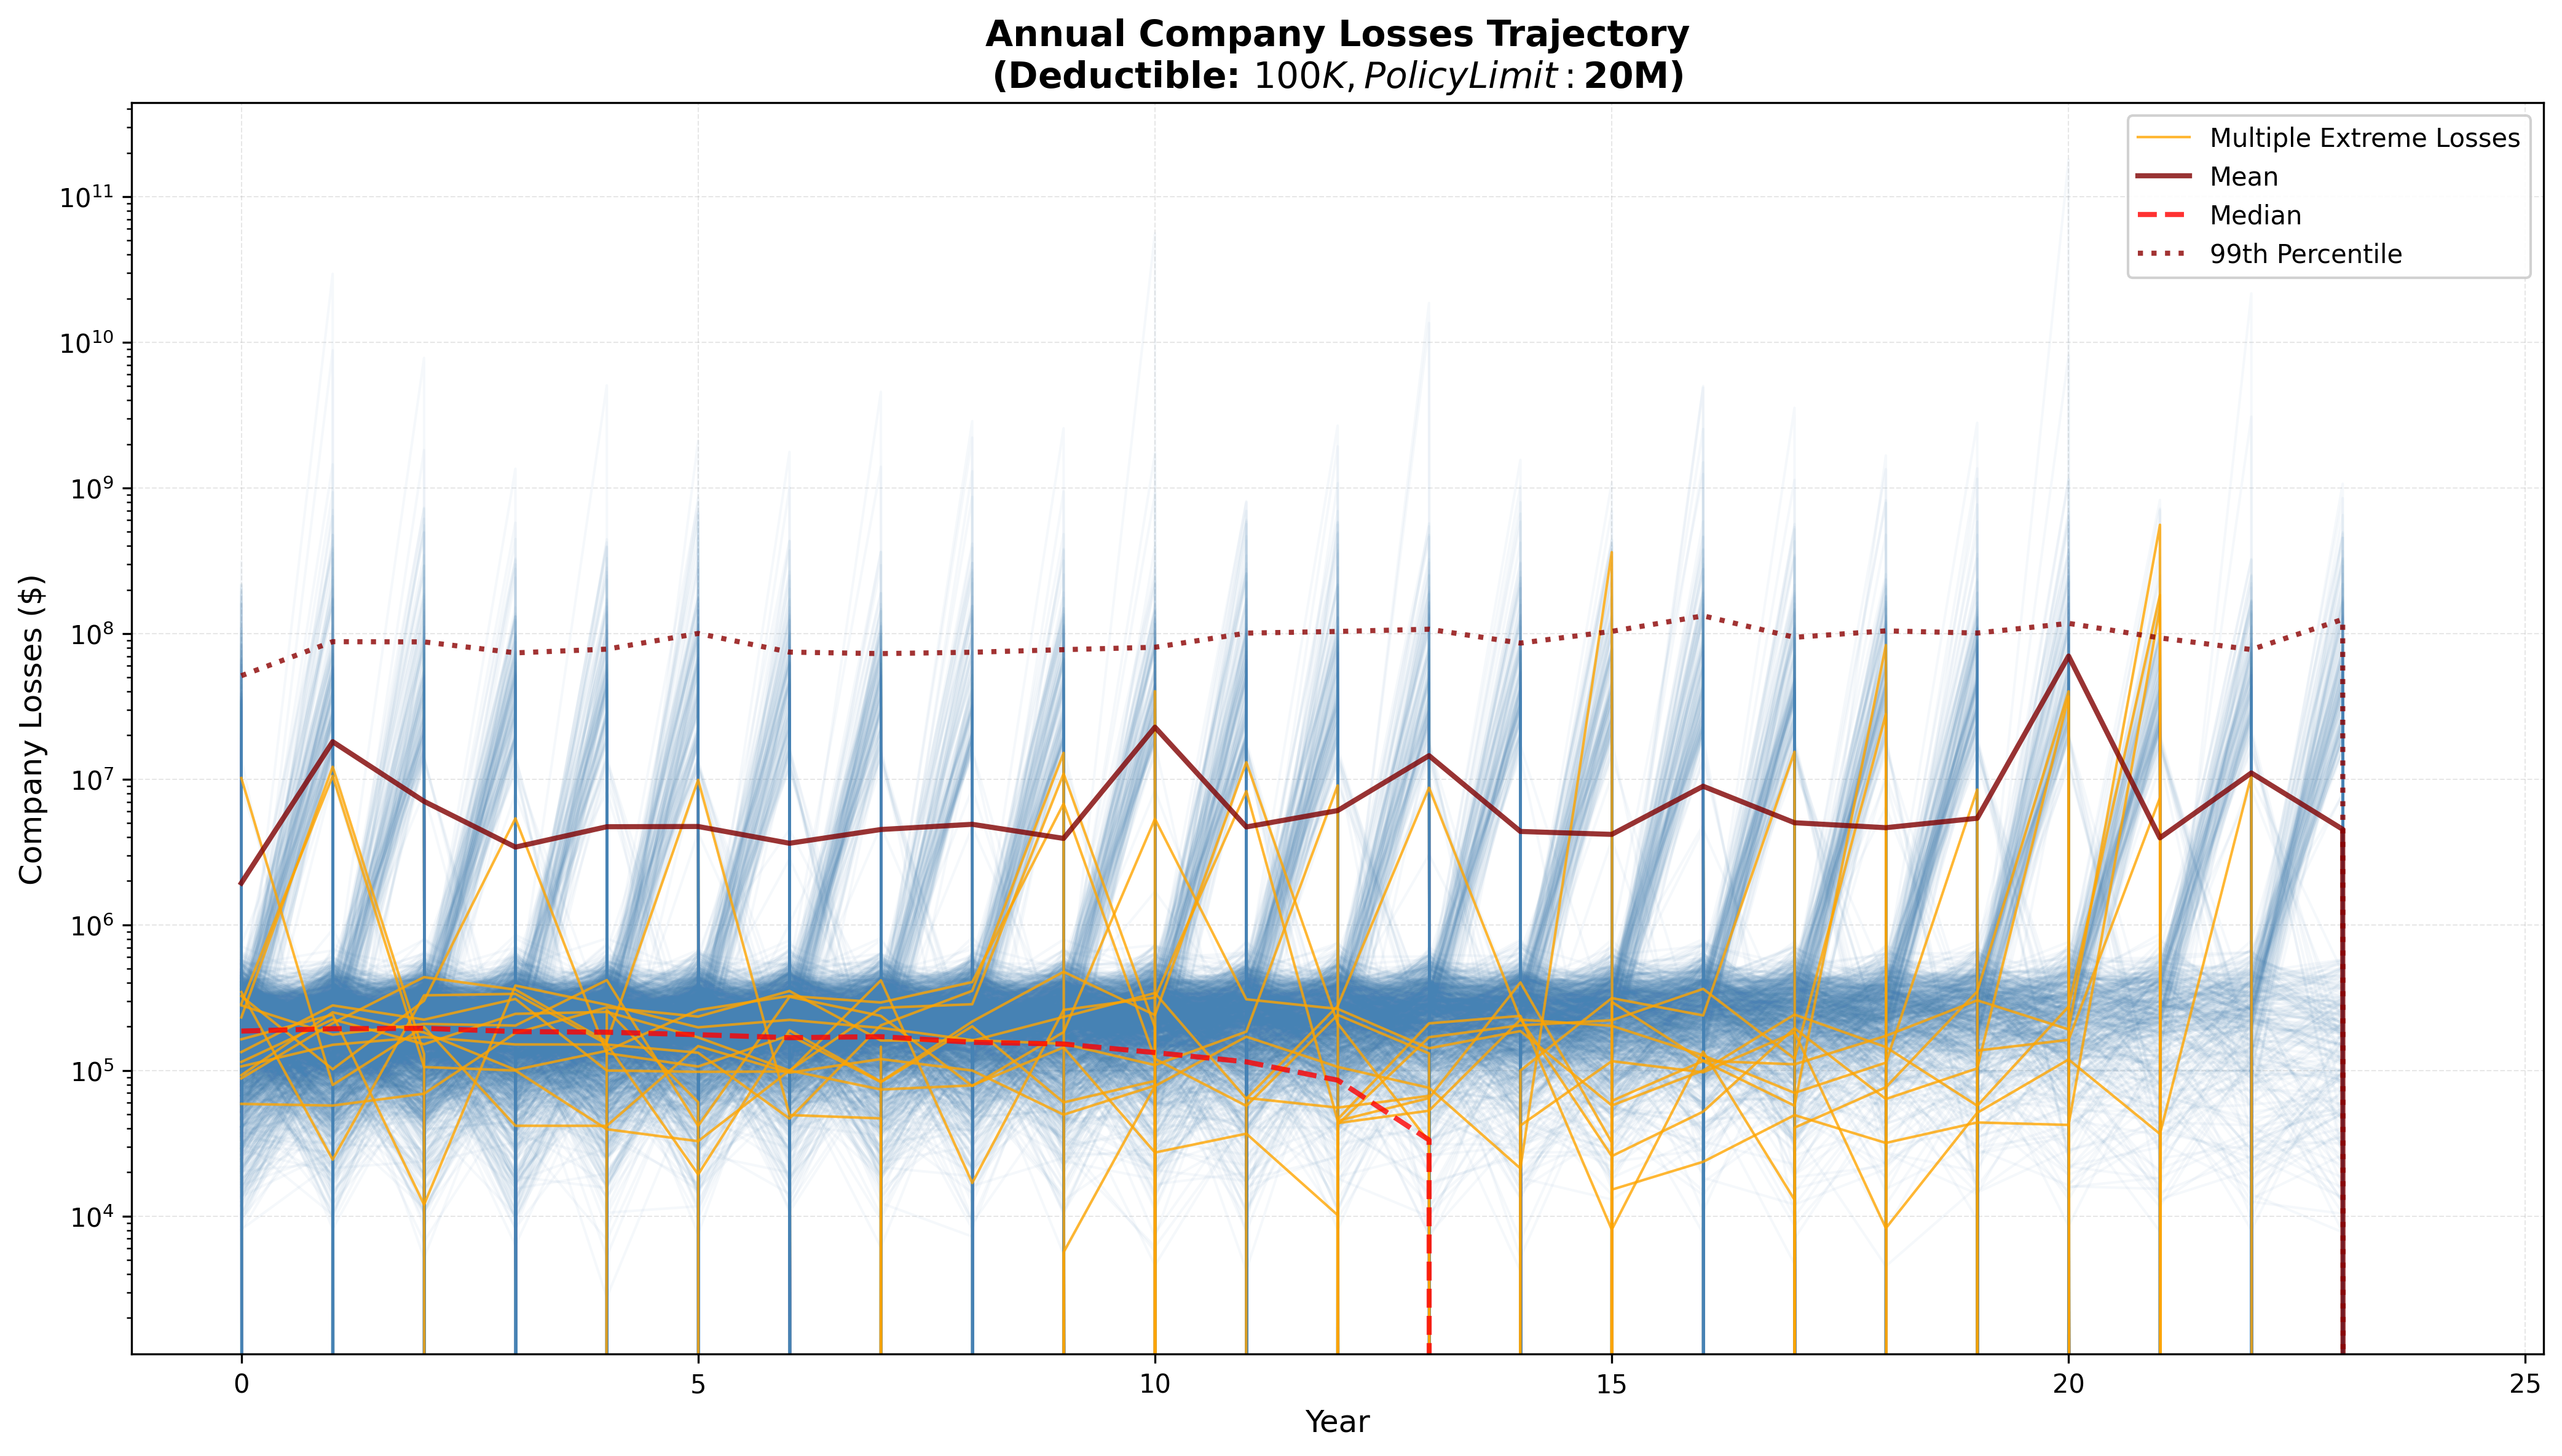


Company Loss Statistics (across all scenarios and years):
  Mean: $9,085,495
  Median: $66,016
  Std Dev: $723,024,640
  Min: $0
  Max: $179,103,989,760

Simulations with multiple years exceeding $5M:
  Count: 13 (0.5%)

Proportion of losses above policy limit:
  0.25% of all loss events


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Extract annual retained losses data for bankrupt companies
company_losses = loaded_sample_data.retained_losses[bankrupt_idxs]

deductible = 100_000
policy_limit = 20_000_000

# Identify simulations with multiple years exceeding 1e7
threshold = 5e6
exceedances_per_sim = (company_losses > threshold).sum(axis=1)
multiple_exceedances_mask = exceedances_per_sim >= 2
multiple_exceedances_idxs = np.where(multiple_exceedances_mask)[0]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# Plot each scenario with low alpha
years = np.arange(0, loaded_sample_data.annual_losses.shape[1])
for i in range(company_losses.shape[0]):
    if i not in multiple_exceedances_idxs:
        # Blue lines for other simulations
        ax.plot(years, company_losses[i, :], alpha=0.05, color='steelblue', linewidth=1)

for i in range(company_losses.shape[0]):
    if i in multiple_exceedances_idxs:
        # Orange lines for simulations with multiple exceedances
        ax.plot(years, company_losses[i, :], alpha=0.8, color='orange', linewidth=1, label='Multiple Extreme Losses')

multiple_label = 'Multiple Extreme Losses'
label_seen = False
for line in ax.lines:
    if line.get_label() == multiple_label:
        if label_seen:
            line.set_label('_nolegend_')
        else:
            label_seen = True
mean_company_loss = company_losses.mean(axis=0)
median_company_loss = np.median(company_losses, axis=0)
p99_company_loss = np.percentile(company_losses, 99, axis=0)

ax.plot(years, mean_company_loss, color='maroon', linewidth=2, label='Mean', alpha=0.8)
ax.plot(years, median_company_loss, color='red', linewidth=2, label='Median', alpha=0.8, linestyle='--')
ax.plot(years, p99_company_loss, color='darkred', linewidth=2, label='99th Percentile', alpha=0.8, linestyle=':')

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Company Losses ($)', fontsize=12)
ax.set_title(f'Annual Company Losses Trajectory\n(Deductible: ${deductible/1000:,.0f}K, Policy Limit: ${policy_limit/1e6:,.0f}M)',
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.legend(loc='upper right', framealpha=0.9)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCompany Loss Statistics (across all scenarios and years):")
print(f"  Mean: ${company_losses.mean():,.0f}")
print(f"  Median: ${np.median(company_losses):,.0f}")
print(f"  Std Dev: ${company_losses.std():,.0f}")
print(f"  Min: ${company_losses.min():,.0f}")
print(f"  Max: ${company_losses.max():,.0f}")
print(f"\nSimulations with multiple years exceeding ${threshold/1e6:.0f}M:")
print(f"  Count: {len(multiple_exceedances_idxs)} ({len(multiple_exceedances_idxs)/len(company_losses)*100:.1f}%)")
print(f"\nProportion of losses above policy limit:")
annual_losses = loaded_sample_data.annual_losses
print(f"  {(annual_losses > policy_limit + deductible).sum() / annual_losses.size * 100:.2f}% of all loss events")

In [81]:
len(loaded_sample_data.final_assets[loaded_sample_data.final_assets <= 10_000]) / len(loaded_sample_data.final_assets)

0.00552

In [82]:
sorted(loaded_sample_data.final_assets)[:]

[np.float32(3645.7483),
 np.float32(4991.614),
 np.float32(5677.124),
 np.float32(6117.8936),
 np.float32(8141.947),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np.float32(10000.0),
 np

In [83]:
import pickle
import re
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image
from scipy.stats import skew, kurtosis
from time import perf_counter
from tqdm.auto import tqdm

from ergodic_insurance.monte_carlo import SimulationResults


def _parse_number(text):
    text = text.strip().replace(",", "")
    m = re.fullmatch(r'([+-]?\d+(?:\.\d+)?)([KMB])?$', text, re.I)
    if not m:
        # fallback: plain int/float or leave as-is
        try:
            return int(text)
        except ValueError:
            try:
                return float(text)
            except ValueError:
                return text
    num = float(m.group(1))
    mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}.get((m.group(2) or "").upper(), 1)
    val = num * mult
    return int(val) if val.is_integer() else val


def parse_config_key(key: str) -> dict:
    parts = re.split(r"\s*-\s*", key.strip())
    out = {}
    for part in parts:
        if not part:
            continue

        # e.g. "Cap (100M)"
        m = re.match(r"^([A-Za-z_%]+)\s*\(\s*([^)]+)\s*\)$", part)
        if m:
            out[m.group(1)] = _parse_number(m.group(2))
            continue

        # e.g. "0K Sims" or "50 Yrs"
        m = re.match(r"^([+-]?\d+(?:\.\d+)?)\s*([KMB])?\s*([A-Za-z_]+)$", part)
        if m:
            value = _parse_number((m.group(1) or "") + (m.group(2) or ""))
            out[m.group(3)] = value
            continue

        # flags like "NOINS"
        if part.upper() == "NOINS":
            out["NOINS"] = True
        else:
            out["NOINS"] = False

    return out

results_dir = Path(results_dir)

sample_files = "Cap (10M) - Ded (250K)*.pkl"
sample_files = "*.pkl"

pkl_paths = sorted(results_dir.glob(sample_files))

qs = np.arange(0.01, 1.00, 0.01) # Growth Rate Quantiles

all_configurations = {}

# Create an empty DataFrame with specified columns
df_qs = [0.01, 0.05] + np.arange(0.1, 0.8, 0.1).tolist() + [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
column_names = [key for key in parse_config_key(sample_file).keys() if key != 'Sims']
column_names += ['growth_rate_mean', 'growth_rate_std', 'growth_rate_cv', 'growth_rate_skewness',
                'growth_rate_kurtosis', 'growth_rate_hyperskewness', 'growth_rate_hyperkurtosis']
column_names += [f'growth_rate_q{q*100:.0f}' for q in df_qs]
df_cte = [0.005, 0.01, 0.05]
column_names += [f'growth_rate_cte_q{q*100:.1f}' for q in df_cte]
column_names += [f'risk_of_ruin_{age}' for age in loaded_sample_data.ruin_probability.keys()]
# column_names += ['risk_of_ruin']
all_df = pd.DataFrame(columns=column_names)
column_names

['Cap',
 'Ded',
 'LR',
 'Pol_Lim',
 'NOINS',
 'growth_rate_mean',
 'growth_rate_std',
 'growth_rate_cv',
 'growth_rate_skewness',
 'growth_rate_kurtosis',
 'growth_rate_hyperskewness',
 'growth_rate_hyperkurtosis',
 'growth_rate_q1',
 'growth_rate_q5',
 'growth_rate_q10',
 'growth_rate_q20',
 'growth_rate_q30',
 'growth_rate_q40',
 'growth_rate_q50',
 'growth_rate_q60',
 'growth_rate_q70',
 'growth_rate_q75',
 'growth_rate_q80',
 'growth_rate_q85',
 'growth_rate_q90',
 'growth_rate_q95',
 'growth_rate_q99',
 'growth_rate_cte_q0.5',
 'growth_rate_cte_q1.0',
 'growth_rate_cte_q5.0',
 'risk_of_ruin_5',
 'risk_of_ruin_10',
 'risk_of_ruin_15',
 'risk_of_ruin_20',
 'risk_of_ruin_25']

In [84]:

row_data = {key: val for (key, val) in parse_config_key(sample_file).items() if key != 'Sims'}
row_data['growth_rate_mean'] = loaded_sample_data.growth_rates.mean()
row_data['growth_rate_std'] = loaded_sample_data.growth_rates.std(ddof=1)
row_data['growth_rate_cv'] = row_data['growth_rate_std'] / row_data['growth_rate_mean']
row_data['growth_rate_skewness'] = skew(loaded_sample_data.growth_rates)
row_data['growth_rate_kurtosis'] = kurtosis(loaded_sample_data.growth_rates)  # Excess (-3)
standardized_data = (loaded_sample_data.growth_rates - row_data['growth_rate_mean']) / row_data['growth_rate_std']
row_data['growth_rate_hyperskewness'] = np.mean(standardized_data**5)
row_data['growth_rate_hyperkurtosis'] = np.mean(standardized_data**6)
row_data = row_data | {f'growth_rate_q{q*100:.0f}': val for q, val in zip(df_qs, np.quantile(loaded_sample_data.growth_rates, df_qs))}
row_data = row_data | {f'growth_rate_cte_q{q*100:.1f}': val for q, val in zip(df_cte, np.quantile(loaded_sample_data.growth_rates, df_cte))}
row_data = row_data | {f'risk_of_ruin_{age}': ror for (age, ror) in loaded_sample_data.ruin_probability.items()}
# row_data['risk_of_ruin'] = len(loaded_sample_data.final_assets[loaded_sample_data.final_assets <= 10_000]) / len(loaded_sample_data.final_assets)
row_data

{'Cap': 5000000,
 'Ded': 100000,
 'LR': 0.6,
 'Pol_Lim': 1000000,
 'NOINS': False,
 'growth_rate_mean': np.float64(0.006917807930605866),
 'growth_rate_std': np.float64(0.04722372849698686),
 'growth_rate_cv': np.float64(6.826400641749384),
 'growth_rate_skewness': np.float64(-3.039912358747634),
 'growth_rate_kurtosis': np.float64(8.914101594892022),
 'growth_rate_hyperskewness': np.float64(-49.481405817329104),
 'growth_rate_hyperkurtosis': np.float64(220.760164639913),
 'growth_rate_q1': np.float64(-0.16567344695329667),
 'growth_rate_q5': np.float64(-0.13402943536639214),
 'growth_rate_q10': np.float64(-0.026625567860901336),
 'growth_rate_q20': np.float64(0.007907650247216227),
 'growth_rate_q30': np.float64(0.017068825662136078),
 'growth_rate_q40': np.float64(0.0216865960508585),
 'growth_rate_q50': np.float64(0.02448451705276966),
 'growth_rate_q60': np.float64(0.026351010799407958),
 'growth_rate_q70': np.float64(0.027590839192271233),
 'growth_rate_q75': np.float64(0.02804631

In [85]:
if not pkl_paths:
    print(f"No pickle files found in {results_dir}.")
else:
    try:
        iterator = tqdm(pkl_paths, desc="Processing pickle files", unit="file")
    except Exception:
        iterator = pkl_paths  # fallback without progress bar

    start_time = perf_counter()
    for idx, path in enumerate(iterator, 1):
        if idx > 1:
            elapsed = perf_counter() - start_time
            avg = elapsed / (idx - 1)
            remaining = avg * (len(pkl_paths) - (idx - 1))
            if hasattr(iterator, "set_postfix"):
                iterator.set_postfix(avg_s=f"{avg:.2f}", eta_s=f"{remaining:.1f}")
        try:
            with open(path, "rb") as f:
                one_config = pickle.load(f)
                growth_rate = one_config.growth_rates.mean()
                growth_rate_ci = {str(q): val for q, val in zip(qs, np.quantile(one_config.growth_rates, qs))}
                ror = one_config.ruin_probability

                # Update the dictionary
                all_configurations[path.stem] = {
                    "growth_rate": growth_rate,
                    "growth_rate_ci": growth_rate_ci,
                    "risk_of_ruin": ror
                    # "annual_losses": one_config.annual_losses
                }

                # Update the DataFrame
                row_data = {key: val for (key, val) in parse_config_key(path.stem).items() if key != 'Sims'}
                row_data['growth_rate_mean'] = one_config.growth_rates.mean()
                row_data['growth_rate_std'] = one_config.growth_rates.std(ddof=1)
                row_data['growth_rate_cv'] = row_data['growth_rate_std'] / row_data['growth_rate_mean']
                row_data['growth_rate_skewness'] = skew(one_config.growth_rates)
                row_data['growth_rate_kurtosis'] = kurtosis(one_config.growth_rates)  # Excess (-3)
                standardized_data = (one_config.growth_rates - row_data['growth_rate_mean']) / row_data['growth_rate_std']
                row_data['growth_rate_hyperskewness'] = np.mean(standardized_data**5)
                row_data['growth_rate_hyperkurtosis'] = np.mean(standardized_data**6)
                row_data = row_data | {f'growth_rate_q{q*100:.0f}': val for q, val in zip(df_qs, np.quantile(one_config.growth_rates, df_qs))}
                row_data = row_data | {f'growth_rate_cte_q{q*100:.1f}': val for q, val in zip(df_cte, np.quantile(one_config.growth_rates, df_cte))}
                row_data = row_data | {f'risk_of_ruin_{age}': ror for (age, ror) in one_config.ruin_probability.items()}
                # row_data['risk_of_ruin'] = len(one_config.final_assets[one_config.final_assets <= 10_000]) / len(one_config.final_assets)
                all_df = pd.concat([all_df, pd.DataFrame([row_data], columns=all_df.columns)], ignore_index=True)
        except Exception as e:
            print(f"Skipping {path.name}: {e}")
    print(f"Loaded {len(all_configurations)} pickle files into all_configurations.")

parsed_params_by_key = {k: parse_config_key(k) | all_configurations[k] for k in all_configurations.keys()}
# parsed_params_by_key

Processing pickle files:   0%|          | 0/408 [00:00<?, ?file/s]

C:\Users\alexf\AppData\Local\Temp\ipykernel_53864\3754315005.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat([all_df, pd.DataFrame([row_data], columns=all_df.columns)], ignore_index=True)


Loaded 408 pickle files into all_configurations.


In [86]:
# Replace 'None' string values in X_Th_%le with 0.0 and coerce to float if possible
if 'X_Th_%le' in all_df.columns:
    all_df.loc[all_df['X_Th_%le'].eq('None'), 'X_Th_%le'] = 0.0
    try:
        all_df['X_Th_%le'] = all_df['X_Th_%le'].astype(float)
    except Exception:
        pass

all_df

Cap     Ded   LR     Pol_Lim  NOINS  growth_rate_mean  \
0    100000000  100000  0.6           0    NaN          0.013609   
1    100000000  100000  0.6  1000000000    NaN          0.013404   
2    100000000  100000  0.6   100000000    NaN          0.011205   
3    100000000  100000  0.6    10000000    NaN          0.008385   
4    100000000  100000  0.6   110000000    NaN          0.011457   
..         ...     ...  ...         ...    ...               ...   
403   75000000  100000  0.6    75000000    NaN          0.011045   
404   75000000  100000  0.6    80000000    NaN          0.011258   
405   75000000  100000  0.6    85000000    NaN          0.011653   
406   75000000  100000  0.6    90000000    NaN          0.011680   
407   75000000  100000  0.6    95000000    NaN          0.011729   

     growth_rate_std  growth_rate_cv  growth_rate_skewness  \
0           0.039920        2.933261             -5.354307   
1           0.010741        0.801346            -19.588397   
2           0.028496        2.543190             -6.844083   
3           0.037413        4.461780             -5.278833   
4           0.027830        2.429185             -7.000897   
..               ...             ...                   ...   
403         0.029880        2.705407             -6.433528   
404         0.028939        2.570571             -6.680951   
405         0.028407        2.437758             -6.848962   
406         0.027771        2.377630             -6.879942   
407         0.027274        2.325450             -6.913905   

     growth_rate_kurtosis  ...  growth_rate_q95  growth_rate_q99  \
0               35.655400  ...         0.029548         0.030668   
1              424.167486  ...         0.014328         0.014462   
2               52.624839  ...         0.016537         0.016669   
3               33.571227  ...         0.020400         0.020570   
4               54.912309  ...         0.016510         0.016645   
..                    ...  ...              ...              ...   
403             45.783344  ...         0.016935         0.017090   
404             49.412968  ...         0.016757         0.016908   
405             52.238394  ...         0.016962         0.017116   
406             52.300281  ...         0.016797         0.016949   
407             51.991490  ...         0.016650         0.016803   

     growth_rate_cte_q0.5  growth_rate_cte_q1.0  growth_rate_cte_q5.0  \
0               -0.188884             -0.154951             -0.034219   
1                0.013375              0.013484              0.013656   
2               -0.168862             -0.164937              0.007606   
3               -0.165719             -0.160514             -0.030976   
4               -0.168427             -0.164455              0.010289   
..                    ...                   ...                   ...   
403             -0.168695             -0.164761              0.005012   
404             -0.168613             -0.164660              0.008073   
405             -0.168006             -0.163701              0.009417   
406             -0.167950             -0.163735              0.011196   
407             -0.168628             -0.164197              0.013057   

     risk_of_ruin_5  risk_of_ruin_10  risk_of_ruin_15  risk_of_ruin_20  \
0           0.00738          0.01485          0.02192          0.02935   
1           0.00062          0.00122          0.00180          0.00234   
2           0.00409          0.00806          0.01229          0.01641   
3           0.00714          0.01404          0.02106          0.02748   
4           0.00370          0.00776          0.01186          0.01575   
..              ...              ...              ...              ...   
403         0.00452          0.00934          0.01369          0.01852   
404         0.00438          0.00860          0.01294          0.01717   
405         0.00384          0.00805          0.01221          0.01650   
406         0.0

In [87]:
df_outfile = r"cache\all_df.parquet"
all_df.to_parquet(df_outfile, engine='pyarrow')

In [88]:
outfile = r"cache\parsed_params_by_key.pkl"
out_path = Path(outfile)
if out_path.parent and not out_path.parent.exists():
    out_path.parent.mkdir(parents=True, exist_ok=True)

with open(out_path, "wb") as f:
    pickle.dump(parsed_params_by_key, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Wrote {len(parsed_params_by_key)} configurations to {outfile}")

Wrote 408 configurations to cache\parsed_params_by_key.pkl


In [89]:
# import pickle

# infile = r"cache\parsed_params_by_key.pkl"

# with open(infile, 'rb') as f:
#     parsed_params_by_key = pickle.load(f)
# print(f"Loaded {len(parsed_params_by_key)} configurations to `parsed_params_by_key`")

In [90]:
import pickle
import re
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image
from scipy.stats import skew, kurtosis
from time import perf_counter
from tqdm.auto import tqdm

from ergodic_insurance.monte_carlo import SimulationResults

df_infile = r"cache\all_df.parquet"
all_df = pd.read_parquet(df_infile, engine='pyarrow')

In [91]:
# Replace the first failing comprehension with this safe version:
all_lims = sorted({sc['Pol_Lim'] for sc in parsed_params_by_key.values() if 'Pol_Lim' in sc})
all_lims

[0,
 1000000,
 5000000,
 10000000,
 15000000,
 20000000,
 25000000,
 30000000,
 35000000,
 40000000,
 45000000,
 50000000,
 55000000,
 60000000,
 65000000,
 70000000,
 75000000,
 80000000,
 85000000,
 90000000,
 95000000,
 100000000,
 110000000,
 120000000,
 130000000,
 140000000,
 150000000,
 160000000,
 170000000,
 180000000,
 190000000,
 200000000,
 210000000,
 220000000,
 230000000,
 240000000,
 250000000,
 260000000,
 270000000,
 280000000,
 290000000,
 300000000,
 310000000,
 320000000,
 330000000,
 340000000,
 350000000,
 360000000,
 370000000,
 380000000,
 390000000,
 400000000,
 410000000,
 420000000,
 430000000,
 440000000,
 450000000,
 460000000,
 470000000,
 480000000,
 490000000,
 500000000,
 550000000,
 600000000,
 650000000,
 700000000,
 750000000,
 1000000000]

In [92]:
# Replace the first failing comprehension with this safe version:
all_keys = set().union(*(sc.keys() for sc in parsed_params_by_key.values()))
all_keys

{'Cap',
 'Ded',
 'LR',
 'Pol_Lim',
 'Sims',
 'Yrs',
 'growth_rate',
 'growth_rate_ci',
 'risk_of_ruin'}

In [93]:
for key in all_keys:
    all_key_vals = sorted({str(sc[key]) for sc in parsed_params_by_key.values() if key in sc and type(sc[key]) not in (list, dict, set)})
    if all_key_vals != []:
        print(f"{key}: {all_key_vals}")
    all_key_vals = {type(sc[key]) for sc in parsed_params_by_key.values() if key in sc and type(sc[key]) in (list, dict, set)}
    if all_key_vals != set():
        print(f"{key}: {all_key_vals}")

Sims: ['100000']
Cap: ['10000000', '100000000', '25000000', '5000000', '50000000', '75000000']
risk_of_ruin: {<class 'dict'>}
Ded: ['100000']
LR: ['0.6']
growth_rate_ci: {<class 'dict'>}
Pol_Lim: ['0', '1000000', '10000000', '100000000', '1000000000', '110000000', '120000000', '130000000', '140000000', '15000000', '150000000', '160000000', '170000000', '180000000', '190000000', '20000000', '200000000', '210000000', '220000000', '230000000', '240000000', '25000000', '250000000', '260000000', '270000000', '280000000', '290000000', '30000000', '300000000', '310000000', '320000000', '330000000', '340000000', '35000000', '350000000', '360000000', '370000000', '380000000', '390000000', '40000000', '400000000', '410000000', '420000000', '430000000', '440000000', '45000000', '450000000', '460000000', '470000000', '480000000', '490000000', '5000000', '50000000', '500000000', '55000000', '550000000', '60000000', '600000000', '65000000', '650000000', '70000000', '700000000', '75000000', '75000000

I have the following set of data as a list of dictionaries for 1029 configurations that I'd like to explore visually in Python:

```
'risk_of_ruin': {<class 'dict'>} # Risk of Ruin snapshots at 5-year intervales (5, 10, 15, 20, 25)
'Ded': ['100000'] # Deductible
'X_Scale': ['0.5', '1', '1.5', '2'] # Scale parameter for the Generalized Pareto Distribution (GPD) tail
'X_Th_%le': ['0.0001', '0.0005', '0.001', 'None'] # Threshold percentile for the Generalized Pareto Distribution (GPD) tail
'growth_rate': <class 'float'> # Mean Growth Rate at the end of the simulation
'growth_rate_ci': {<class 'dict'>} # Growth Rate quantiles from 0.01 to 0.99 in increments of 0.01 at the end of the simulation
'Pol_Lim': ['100000000', '200000000', '50000000', '500000000']
'X_Shape': ['0', '1', '1.5', '2', '2.5'] # Shape parameter for the Generalized Pareto Distribution (GPD) tail
'LR': ['0.3', '0.4', '0.5', '0.6', '0.7'] # Loss Ratio (Claims / Premiums), lower implies a higher premium charge for the same expected losses
'Yrs': ['25'] # Simulations were run for 25 years only
'Sims': ['100000'] # Each configuration was run for 100,000 simulations
# There are also configurations without insurance for which there is no 'Pol_Lim', no 'Ded', and no 'LR' parameters. These scenarios are marked with `'NOINS': True`
```

For the first set of plots, I'd like to create an Efficiency Frontier plot with the following parameters:
x-axix: 'risk_of_ruin'
y-axis: 'growth_rate'
Display this curve for each tail configuration in the following setup:
row: 'X_Th_%le'
column: 'X_Shape'
Plot different graphs for each collection of 'X_Scale', which are transformations on the loss distribution with '1' representing a close match, '0.5' representing 0.5 loss density compared to default tail, '2' representing twice the density of the default tail, and so on.
Color represents percentiles, using the pallette "cividis"
Encode different limits as shapes for the median/mean/quantile, so for example, a triangle in different colors represents the same limit (50M)
Shapes are as follows:
'NOINS': plus sign, "P" shape code
'50000000': triangle, "v" shape code
'100000000': square, "s" shape code
'200000000': pentagon, "p" shape code
'500000000': hexagon, "H" shape code

There should be 4 plots (one for each 'X_Scale') with DPI set to 300px that get saved to individual PNG files.


In [94]:
ins_only_vals = [val for val in parsed_params_by_key.values() if val.get('NOINS', False) is False]
len(ins_only_vals)

408

In [95]:
lr = sorted(set(c['LR'] for c in ins_only_vals))
lr

[0.6]

## Plot tSNE

In [96]:
import pickle
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Create cache directory if it doesn't exist
cache_dir = Path("cache")
cache_dir.mkdir(exist_ok=True)

# Prepare the data for t-SNE
print("Preparing data for t-SNE...")

# Create a working copy
df = all_df.copy()

# Convert NOINS to binary (1 for True, 0 for False/NaN)
df['NOINS'] = df['NOINS'].fillna(False).astype(int)

# Fill NaNs with 0 for all other columns
df = df.fillna(0)

# Select feature columns (both inputs and outputs)
input_features = ['Cap', 'Ded', 'LR', 'Pol_Lim']
output_features = ['growth_rate_mean', 'growth_rate_std', 'growth_rate_cv', 'growth_rate_skewness', 
                   'growth_rate_kurtosis', 'growth_rate_hyperskewness', 'growth_rate_hyperkurtosis']
output_features += [col for col in df.columns if col.startswith('growth_rate_q')]
output_features += [col for col in df.columns if col.startswith('growth_rate_cte_')]
output_features += [col for col in df.columns if col.startswith('risk_of_ruin_')]

all_features = input_features + output_features
print(f"Using {len(all_features)} features: {len(input_features)} inputs + {len(output_features)} outputs")

# Extract feature matrix
X = df[all_features].values

# Standardize features (critical for t-SNE)
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# t-SNE hyperparameters
perplexity = 30
learning_rate = 100
max_iter = 1000
random_state = 42

# Check if cached t-SNE embedding exists
tsne_cache_file = cache_dir / "tsne_embedding.pkl"

if tsne_cache_file.exists():
    print(f"Loading cached t-SNE embedding from {tsne_cache_file}...")
    with open(tsne_cache_file, "rb") as f:
        cache_data = pickle.load(f)
        X_tsne = cache_data['embedding']
        print(f"Loaded cached embedding with shape {X_tsne.shape}")
else:
    print("Running t-SNE (this may take a few minutes)...")
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=random_state,
        verbose=1
    )
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Cache the results
    print(f"Caching t-SNE embedding to {tsne_cache_file}...")
    cache_data = {
        'embedding': X_tsne,
        'feature_names': all_features,
        'parameters': {
            'perplexity': perplexity,
            'learning_rate': learning_rate,
            'max_iter': max_iter,
            'random_state': random_state
        }
    }
    with open(tsne_cache_file, "wb") as f:
        pickle.dump(cache_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Cached embedding with shape {X_tsne.shape}")

# Add t-SNE coordinates to dataframe
df['tsne_x'] = X_tsne[:, 0]
df['tsne_y'] = X_tsne[:, 1]

print(f"\nt-SNE embedding complete: {X_tsne.shape[0]} points in 2D space")
print(f"X range: [{X_tsne[:, 0].min():.2f}, {X_tsne[:, 0].max():.2f}]")
print(f"Y range: [{X_tsne[:, 1].min():.2f}, {X_tsne[:, 1].max():.2f}]")

Preparing data for t-SNE...
Using 34 features: 4 inputs + 30 outputs
Standardizing features...
Running t-SNE (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.006s...


C:\Users\alexf\AppData\Local\Temp\ipykernel_53864\3982483597.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['NOINS'] = df['NOINS'].fillna(False).astype(int)


[t-SNE] Computed neighbors for 408 samples in 0.257s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 0.968764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.261570
[t-SNE] KL divergence after 1000 iterations: 0.240497
Caching t-SNE embedding to cache\tsne_embedding.pkl...
Cached embedding with shape (408, 2)

t-SNE embedding complete: 408 points in 2D space
X range: [-33.14, 35.52]
Y range: [-15.81, 15.74]


Creating t-SNE visualization colored by Ded...
Saved figure to cache\tsne_by_ded.png


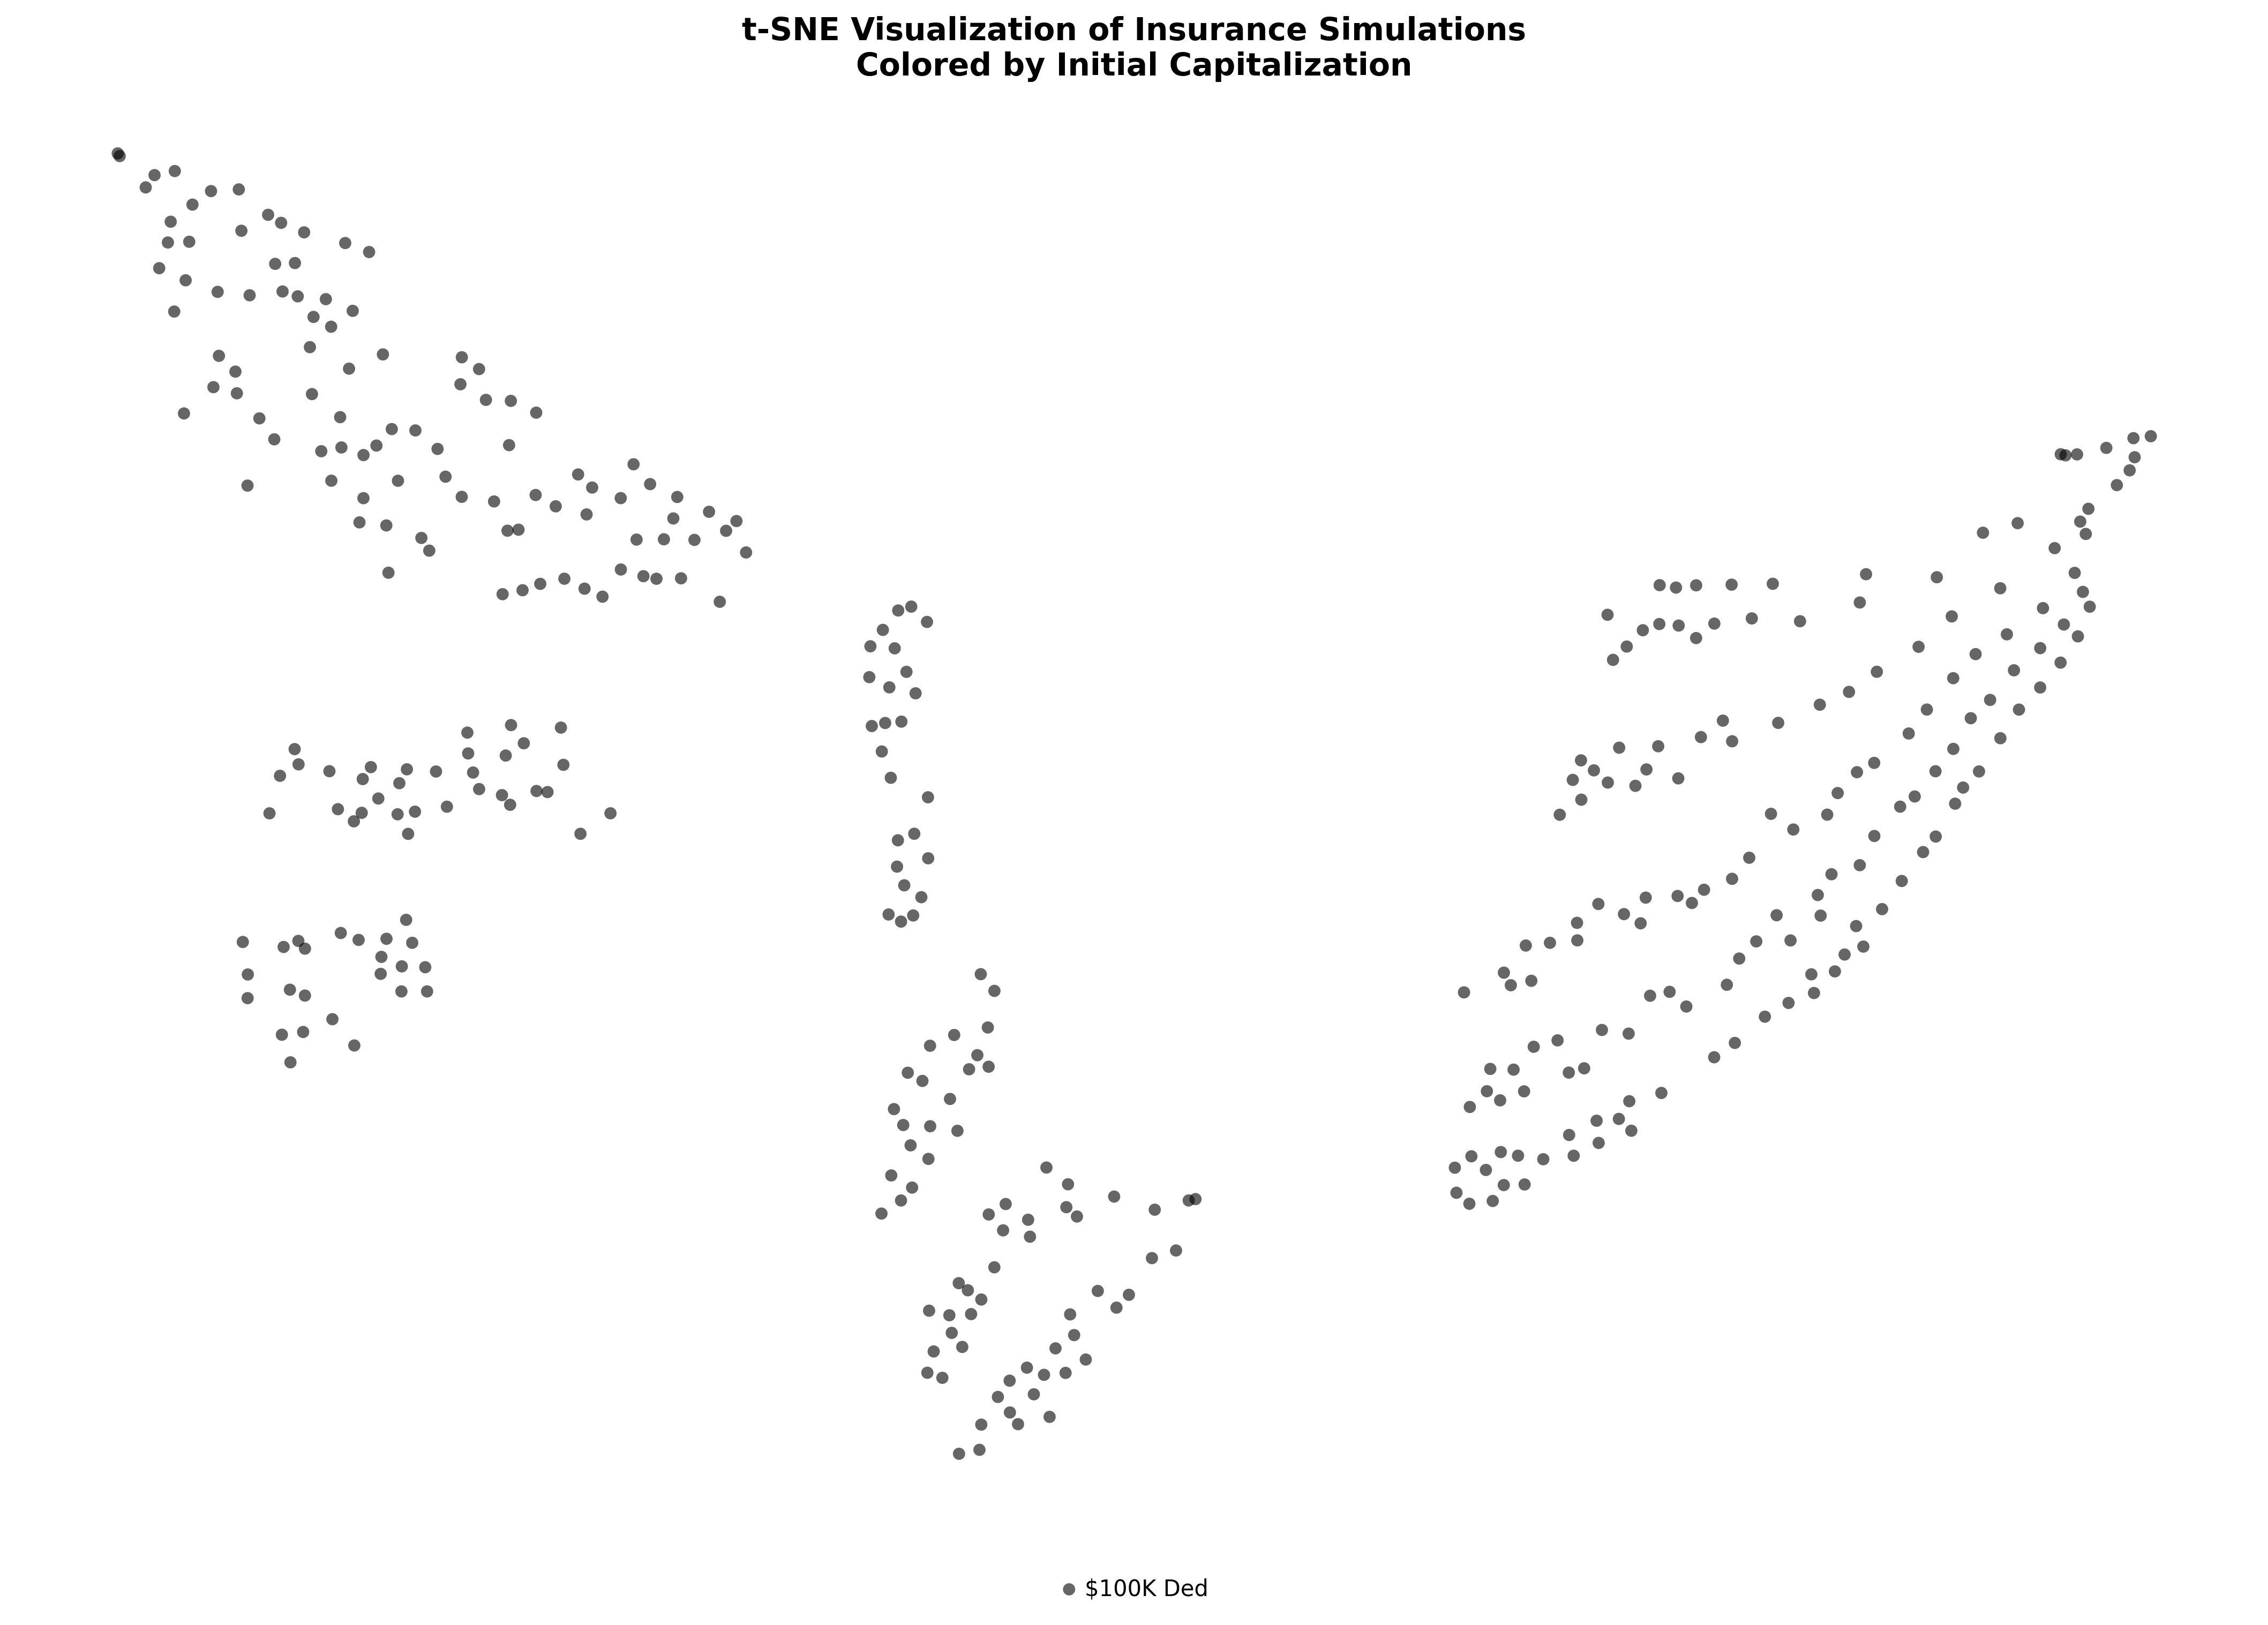


Deductible distribution:
  $100,000: 408 configurations


In [97]:
# Create visualization colored by Ded
print("Creating t-SNE visualization colored by Ded...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Get unique Ded values and create a color map
deds = sorted(df['Ded'].unique())
colors_lim = plt.cm.copper(np.linspace(0, 1, len(deds)))
lim_to_color = dict(zip(deds, colors_lim))

# Plot each deds group
for ded in deds:
    mask = df['Ded'] == ded
    # Format large numbers nicely
    if ded >= 1e9:
        label = f'${ded/1e9:.1f}B Ded'
    elif ded >= 1e6:
        label = f'${ded/1e6:.0f}M Ded'
    elif ded >= 1e3:
        label = f'${ded/1e3:.0f}K Ded'
    else:
        label = f'${ded:,.0f} Ded'
    
    ax.scatter(
        df.loc[mask, 'tsne_x'],
        df.loc[mask, 'tsne_y'],
        c=[lim_to_color[ded]],
        label=label,
        alpha=0.6,
        s=30,
        edgecolors='none'
    )

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Initial Capitalization', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(0.5, -0.027), handlelength=0.8, handletextpad=0.3, loc='upper center', frameon=False, framealpha=0.9, ncol=len(deds))
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file_lim = cache_dir / "tsne_by_ded.png"
plt.savefig(output_file_lim, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file_lim}")

plt.show()

print(f"\nDeductible distribution:")
ded_counts = df['Ded'].value_counts().sort_index()
for ded, count in ded_counts.items():
    if ded == 0:
        print(f"  No Insurance: {count} configurations")
    elif ded >= 1e9:
        print(f"  ${ded/1e9:.1f}B: {count} configurations")
    elif ded >= 1e6:
        print(f"  ${ded/1e6:.0f}M: {count} configurations")
    else:
        print(f"  ${ded:,.0f}: {count} configurations")

Creating t-SNE visualization colored by Pol_Lim...


C:\Users\alexf\AppData\Local\Temp\ipykernel_53864\1878122089.py:52: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(output_file_lim, dpi=300, bbox_inches='tight')


Saved figure to cache\tsne_by_pol_lim.png


c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


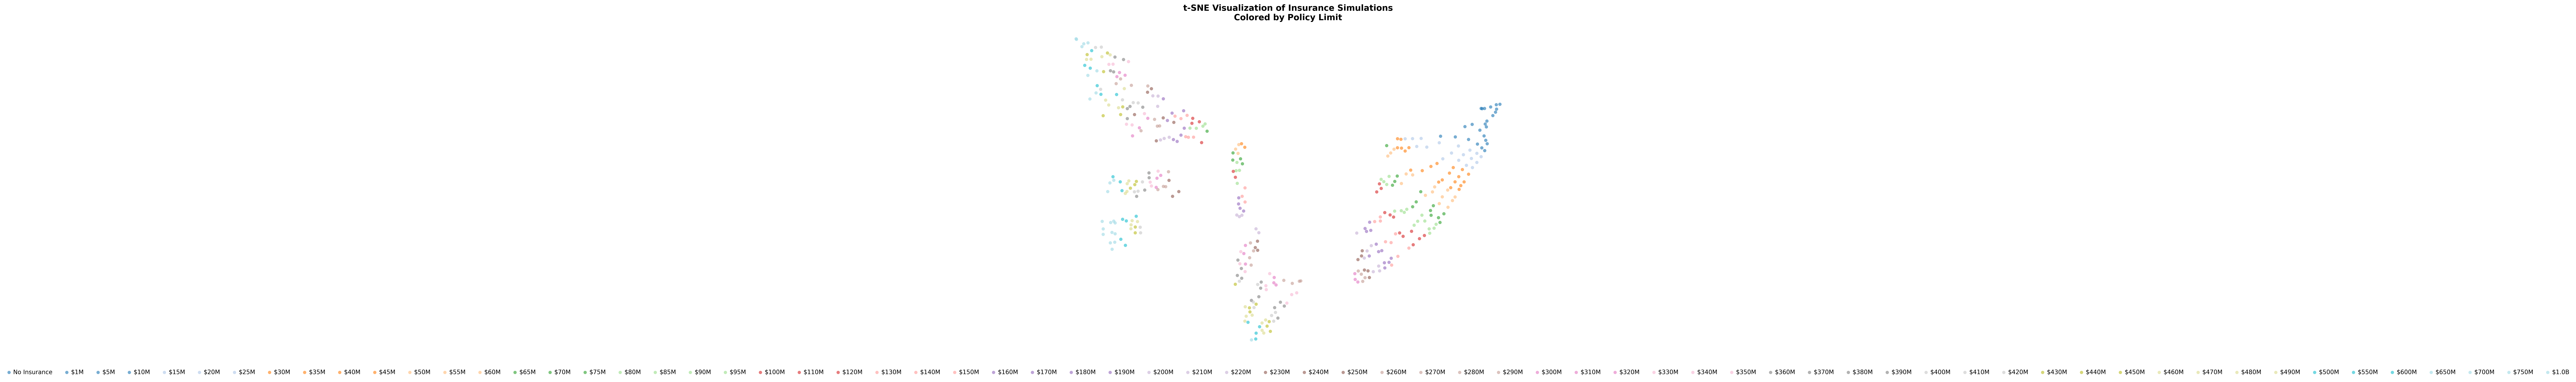


Pol_Lim distribution:
  No Insurance: 6 configurations
  $1M: 6 configurations
  $5M: 6 configurations
  $10M: 6 configurations
  $15M: 6 configurations
  $20M: 6 configurations
  $25M: 6 configurations
  $30M: 6 configurations
  $35M: 6 configurations
  $40M: 6 configurations
  $45M: 6 configurations
  $50M: 6 configurations
  $55M: 6 configurations
  $60M: 6 configurations
  $65M: 6 configurations
  $70M: 6 configurations
  $75M: 6 configurations
  $80M: 6 configurations
  $85M: 6 configurations
  $90M: 6 configurations
  $95M: 6 configurations
  $100M: 6 configurations
  $110M: 6 configurations
  $120M: 6 configurations
  $130M: 6 configurations
  $140M: 6 configurations
  $150M: 6 configurations
  $160M: 6 configurations
  $170M: 6 configurations
  $180M: 6 configurations
  $190M: 6 configurations
  $200M: 6 configurations
  $210M: 6 configurations
  $220M: 6 configurations
  $230M: 6 configurations
  $240M: 6 configurations
  $250M: 6 configurations
  $260M: 6 configurations
  $2

In [98]:
# Create visualization colored by Pol_Lim
print("Creating t-SNE visualization colored by Pol_Lim...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Get unique Pol_Lim values and create a color map
pol_lims = sorted(df['Pol_Lim'].unique())
colors_lim = plt.cm.tab20(np.linspace(0, 1, len(pol_lims)))
lim_to_color = dict(zip(pol_lims, colors_lim))

# Plot each Pol_Lim group
for pol_lim in pol_lims:
    mask = df['Pol_Lim'] == pol_lim
    if pol_lim == 0:
        label = 'No Insurance'
    else:
        # Format large numbers nicely
        if pol_lim >= 1e9:
            label = f'${pol_lim/1e9:.1f}B'
        elif pol_lim >= 1e6:
            label = f'${pol_lim/1e6:.0f}M'
        else:
            label = f'${pol_lim:,.0f}'
    
    ax.scatter(
        df.loc[mask, 'tsne_x'],
        df.loc[mask, 'tsne_y'],
        c=[lim_to_color[pol_lim]],
        label=label,
        alpha=0.6,
        s=30,
        edgecolors='none'
    )

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Policy Limit', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(0.5, -0.027), handlelength=0.8, handletextpad=0.3, loc='upper center', frameon=False, framealpha=0.9, ncol=len(pol_lims))
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file_lim = cache_dir / "tsne_by_pol_lim.png"
plt.savefig(output_file_lim, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file_lim}")

plt.show()

print(f"\nPol_Lim distribution:")
pol_lim_counts = df['Pol_Lim'].value_counts().sort_index()
for lim, count in pol_lim_counts.items():
    if lim == 0:
        print(f"  No Insurance: {count} configurations")
    elif lim >= 1e9:
        print(f"  ${lim/1e9:.1f}B: {count} configurations")
    elif lim >= 1e6:
        print(f"  ${lim/1e6:.0f}M: {count} configurations")
    else:
        print(f"  ${lim:,.0f}: {count} configurations")

Creating t-SNE visualization colored by growth_rate_mean...
Saved figure to cache\tsne_by_growth_rate_mean.png


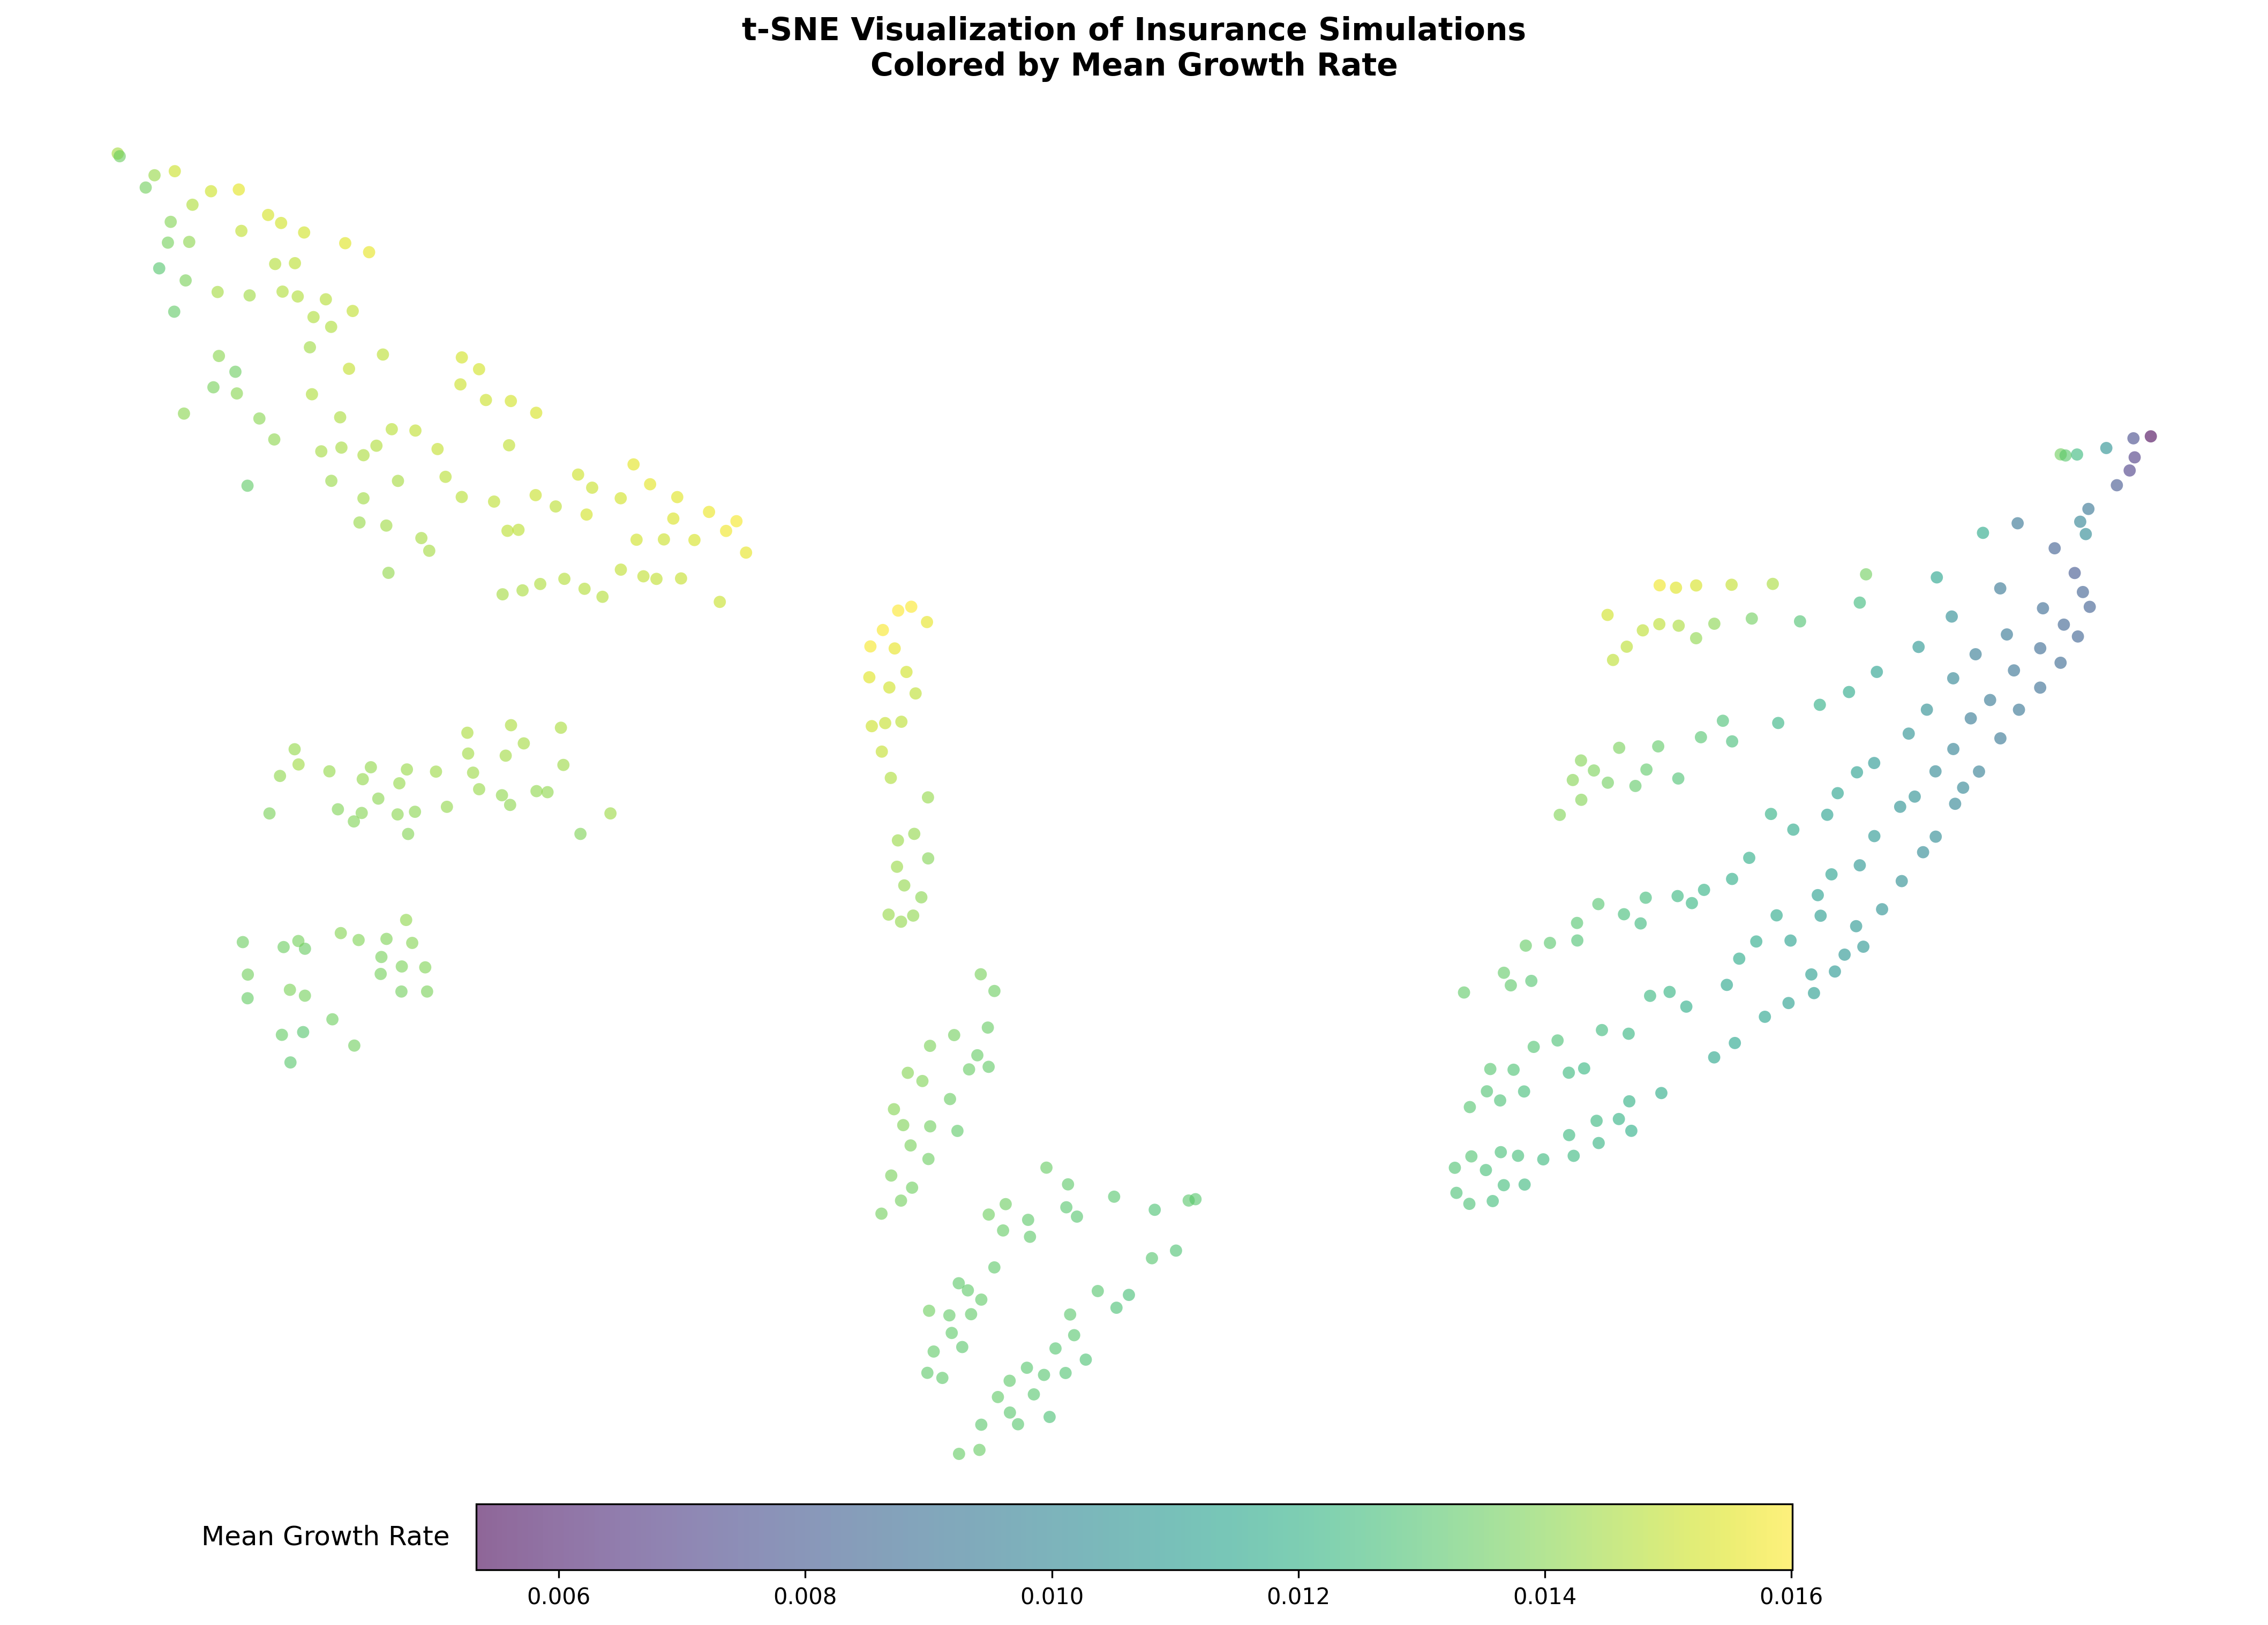


growth_rate_mean statistics:
  Min: 0.005330
  Max: 0.016007
  Mean: 0.013209
  Median: 0.013561


In [99]:
# Create visualization colored by growth_rate_mean
print("Creating t-SNE visualization colored by growth_rate_mean...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_mean'],
    cmap='viridis',
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Mean Growth Rate', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
fig.canvas.draw_idle()
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Mean Growth Rate', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Position the colorbar below the plot, centered horizontally
bbox = ax.get_position()

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_mean.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_mean statistics:")
print(f"  Min: {df['growth_rate_mean'].min():.6f}")
print(f"  Max: {df['growth_rate_mean'].max():.6f}")
print(f"  Mean: {df['growth_rate_mean'].mean():.6f}")
print(f"  Median: {df['growth_rate_mean'].median():.6f}")

Creating t-SNE visualization colored by growth_rate_q50...
Saved figure to cache\tsne_by_growth_rate_q50.png


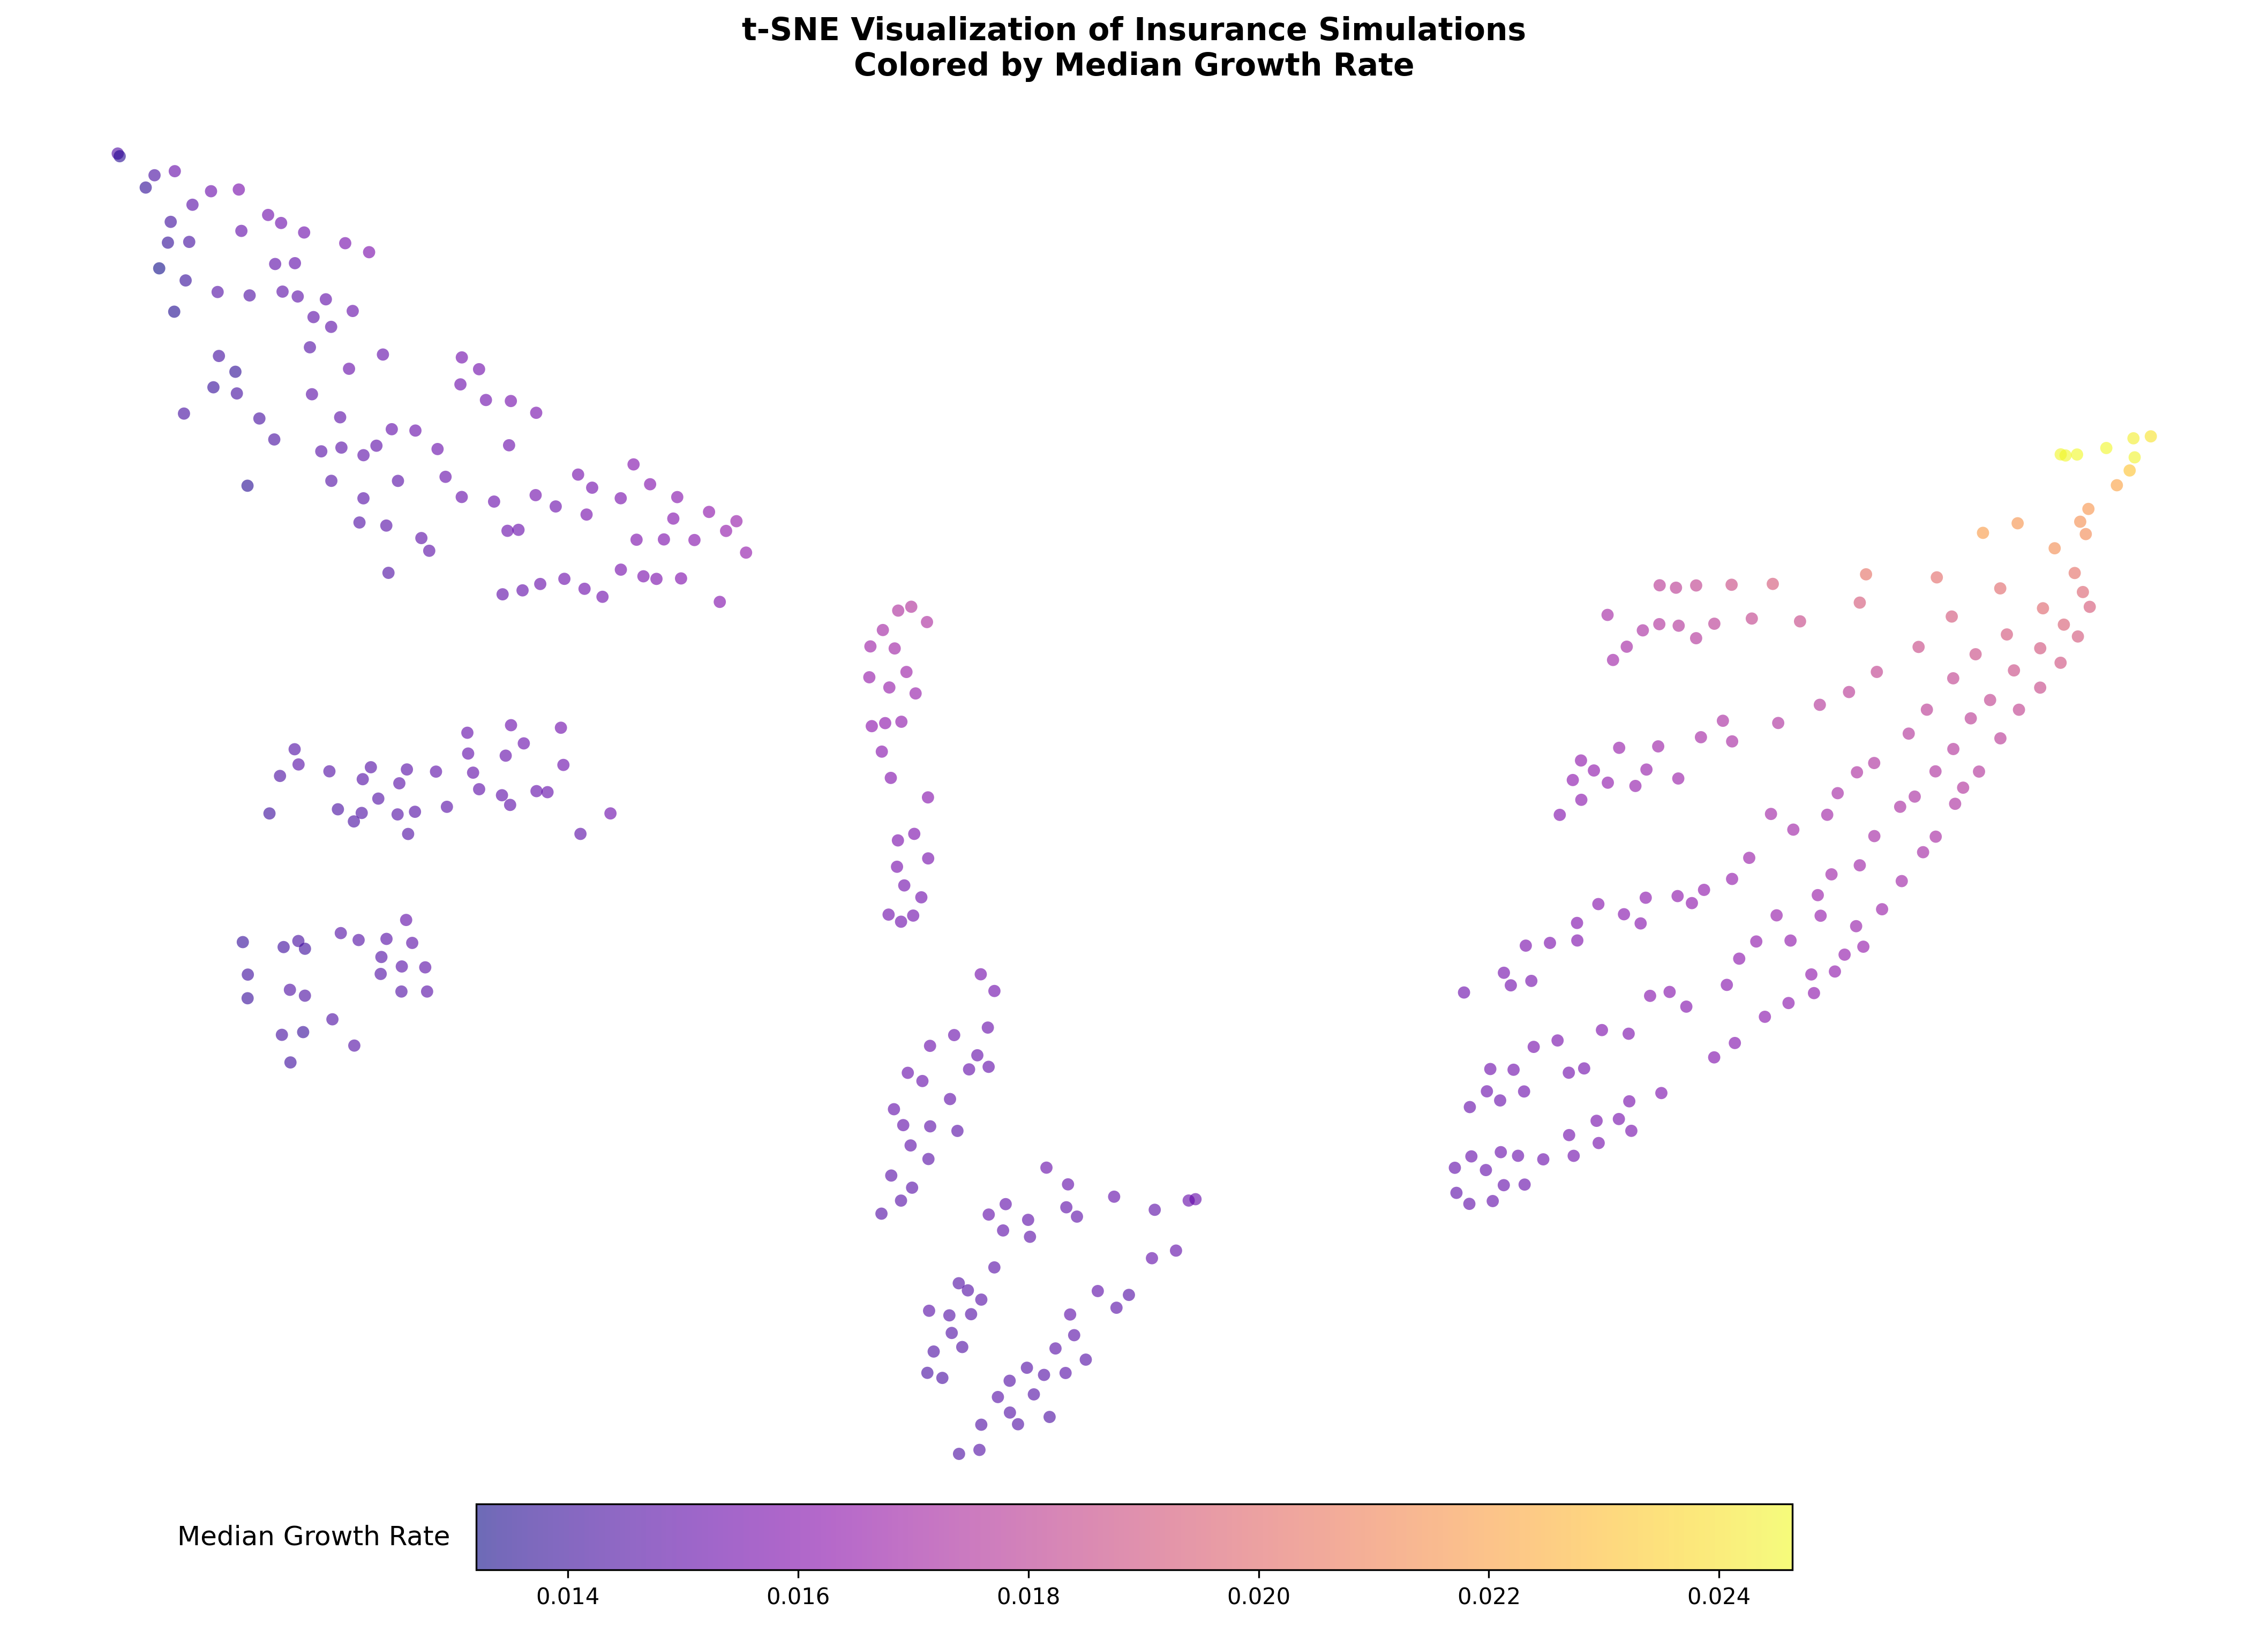


growth_rate_q50 statistics:
  Min: 0.013204
  Max: 0.024636
  Mean: 0.015979
  Median: 0.015367


In [100]:
# Create visualization colored by growth_rate_q50 (median growth rate)
print("Creating t-SNE visualization colored by growth_rate_q50...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_q50'],
    cmap='plasma',
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Median Growth Rate', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Median Growth Rate', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_q50.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_q50 statistics:")
print(f"  Min: {df['growth_rate_q50'].min():.6f}")
print(f"  Max: {df['growth_rate_q50'].max():.6f}")
print(f"  Mean: {df['growth_rate_q50'].mean():.6f}")
print(f"  Median: {df['growth_rate_q50'].median():.6f}")

Creating t-SNE visualization colored by growth_rate_q5...
Saved figure to cache\tsne_by_growth_rate_q5.png


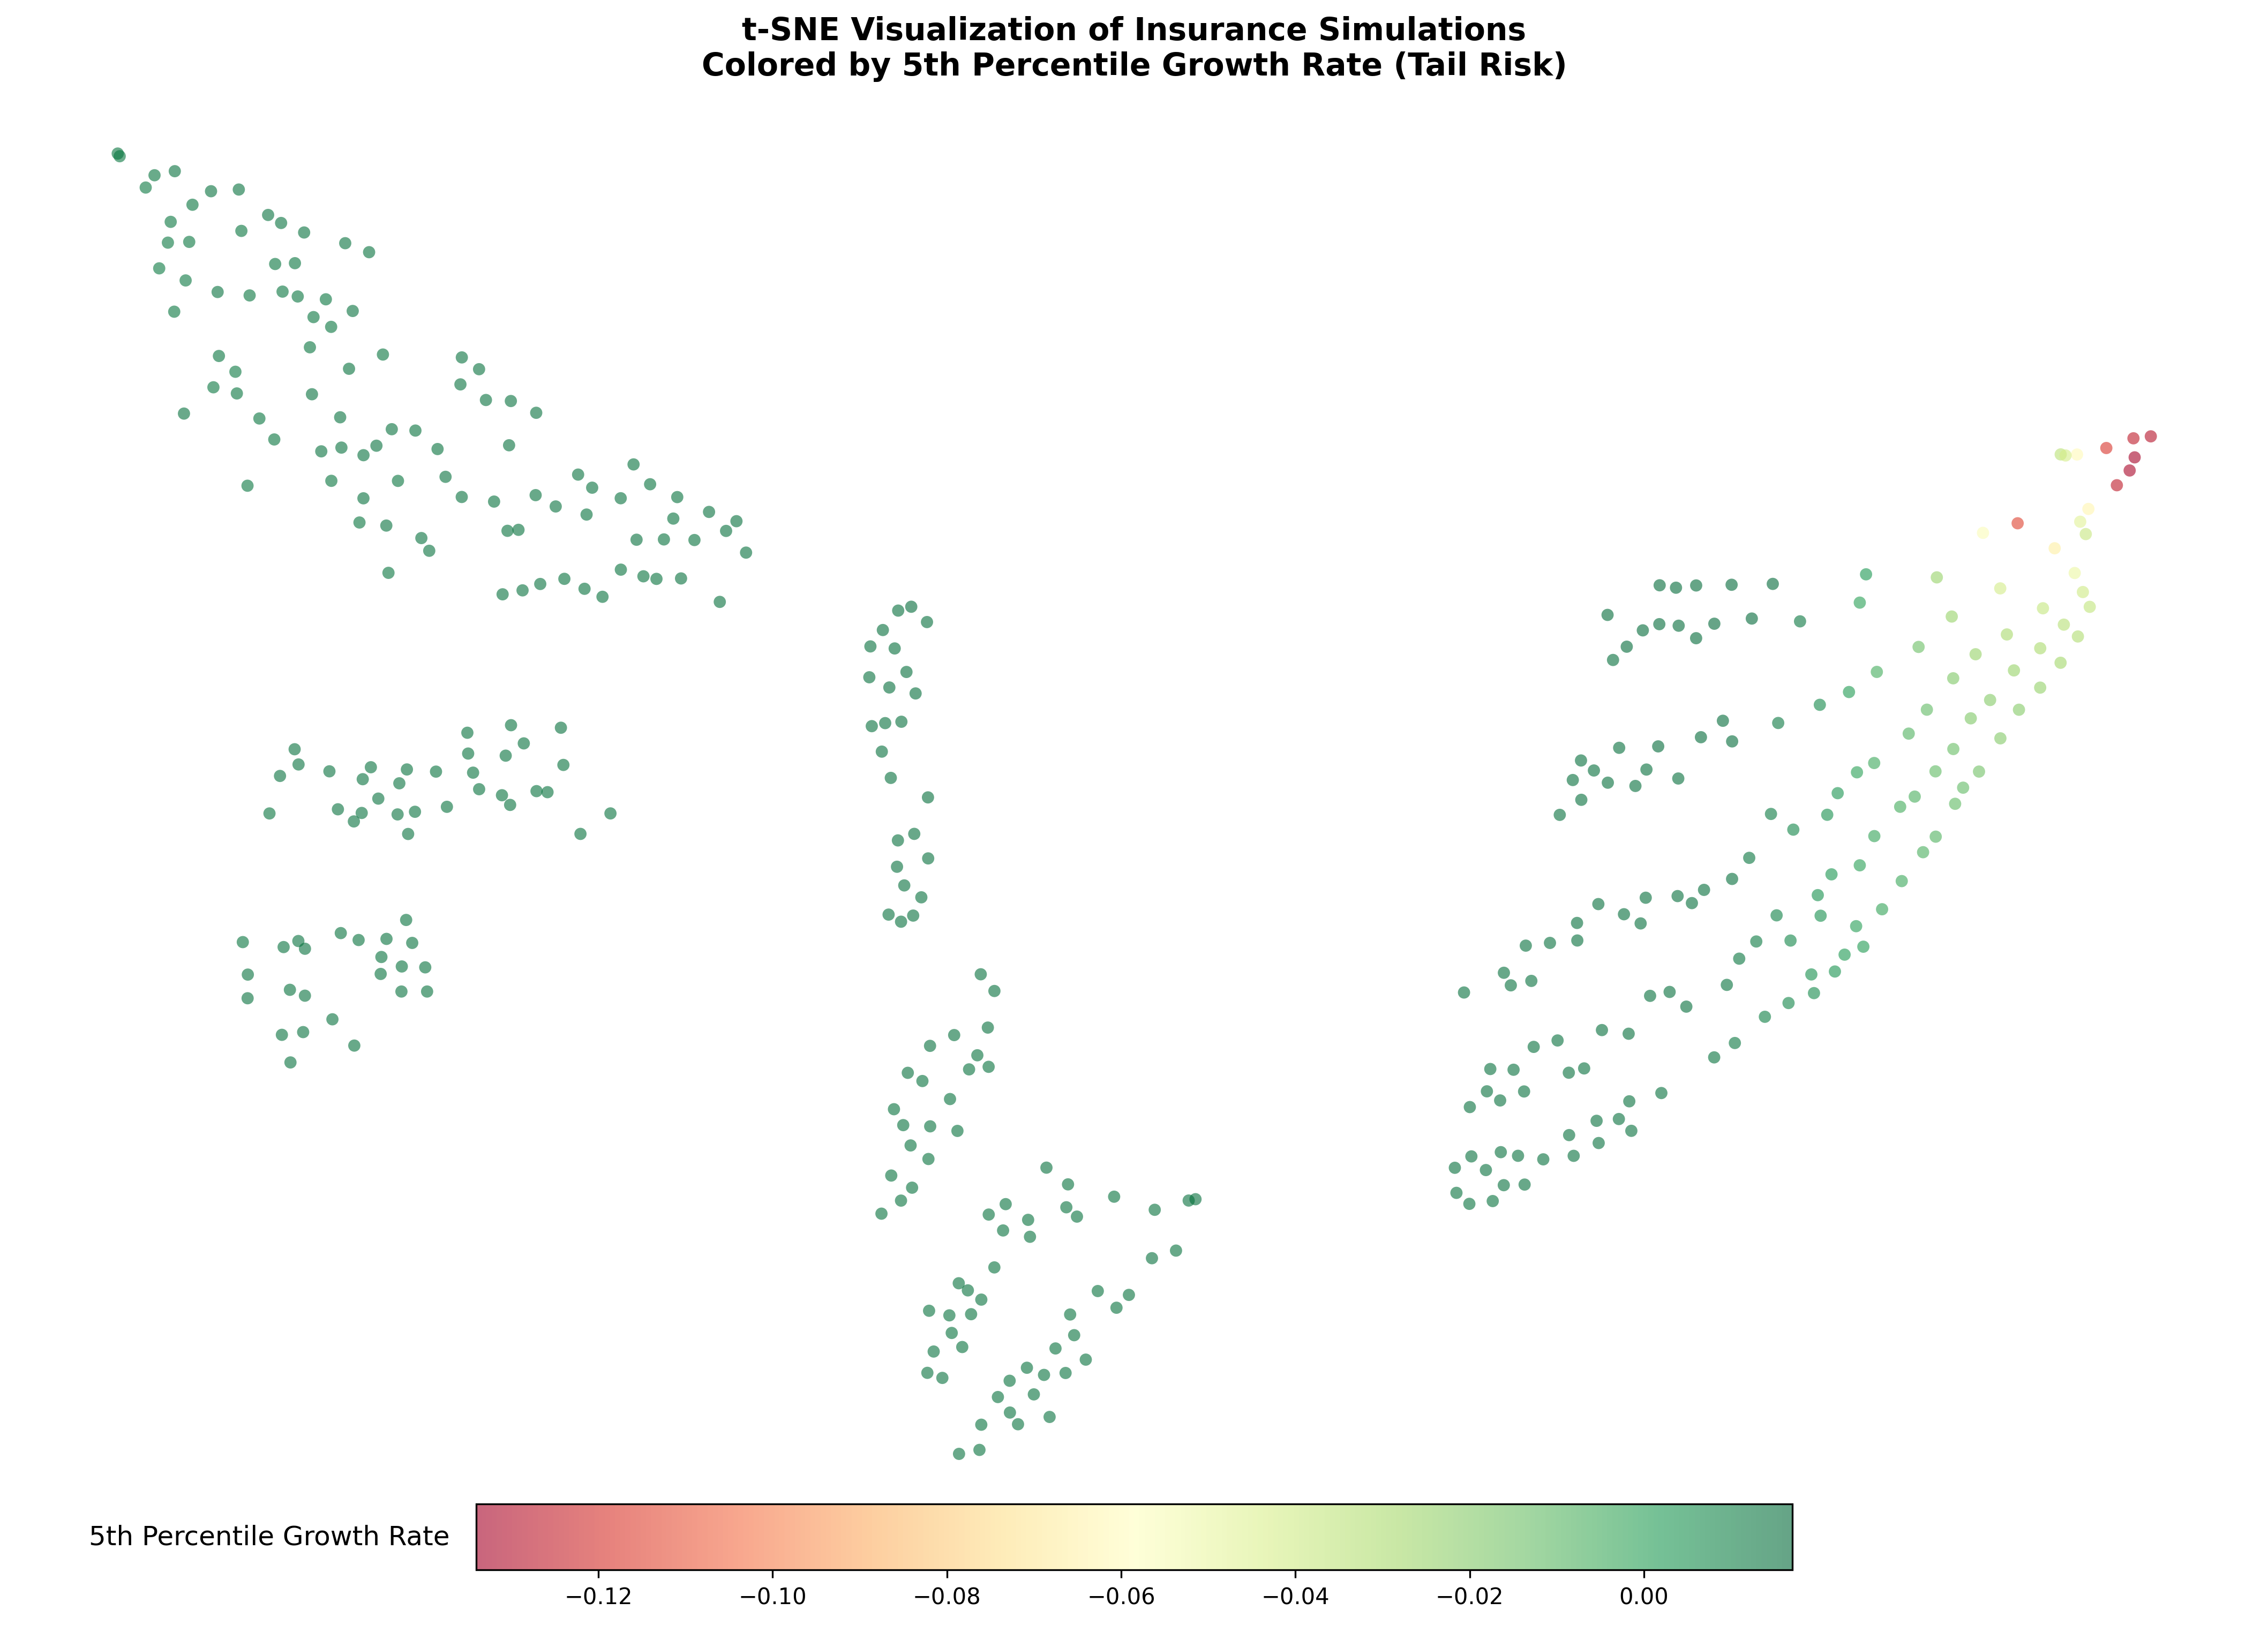


growth_rate_q5 statistics:
  Min: -0.134029
  Max: 0.017037
  Mean: 0.007049
  Median: 0.014191


In [101]:
# Create visualization colored by growth_rate_q5 (5th percentile - tail risk)
print("Creating t-SNE visualization colored by growth_rate_q5...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap (using diverging colormap for risk)
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_q5'],
    cmap='RdYlGn',  # Red for negative/low, green for positive/high
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, '5th Percentile Growth Rate', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by 5th Percentile Growth Rate (Tail Risk)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_q5.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_q5 statistics:")
print(f"  Min: {df['growth_rate_q5'].min():.6f}")
print(f"  Max: {df['growth_rate_q5'].max():.6f}")
print(f"  Mean: {df['growth_rate_q5'].mean():.6f}")
print(f"  Median: {df['growth_rate_q5'].median():.6f}")

Creating t-SNE visualization colored by growth_rate_cte_q1.0...
Saved figure to cache\tsne_by_growth_rate_cte_q1.png


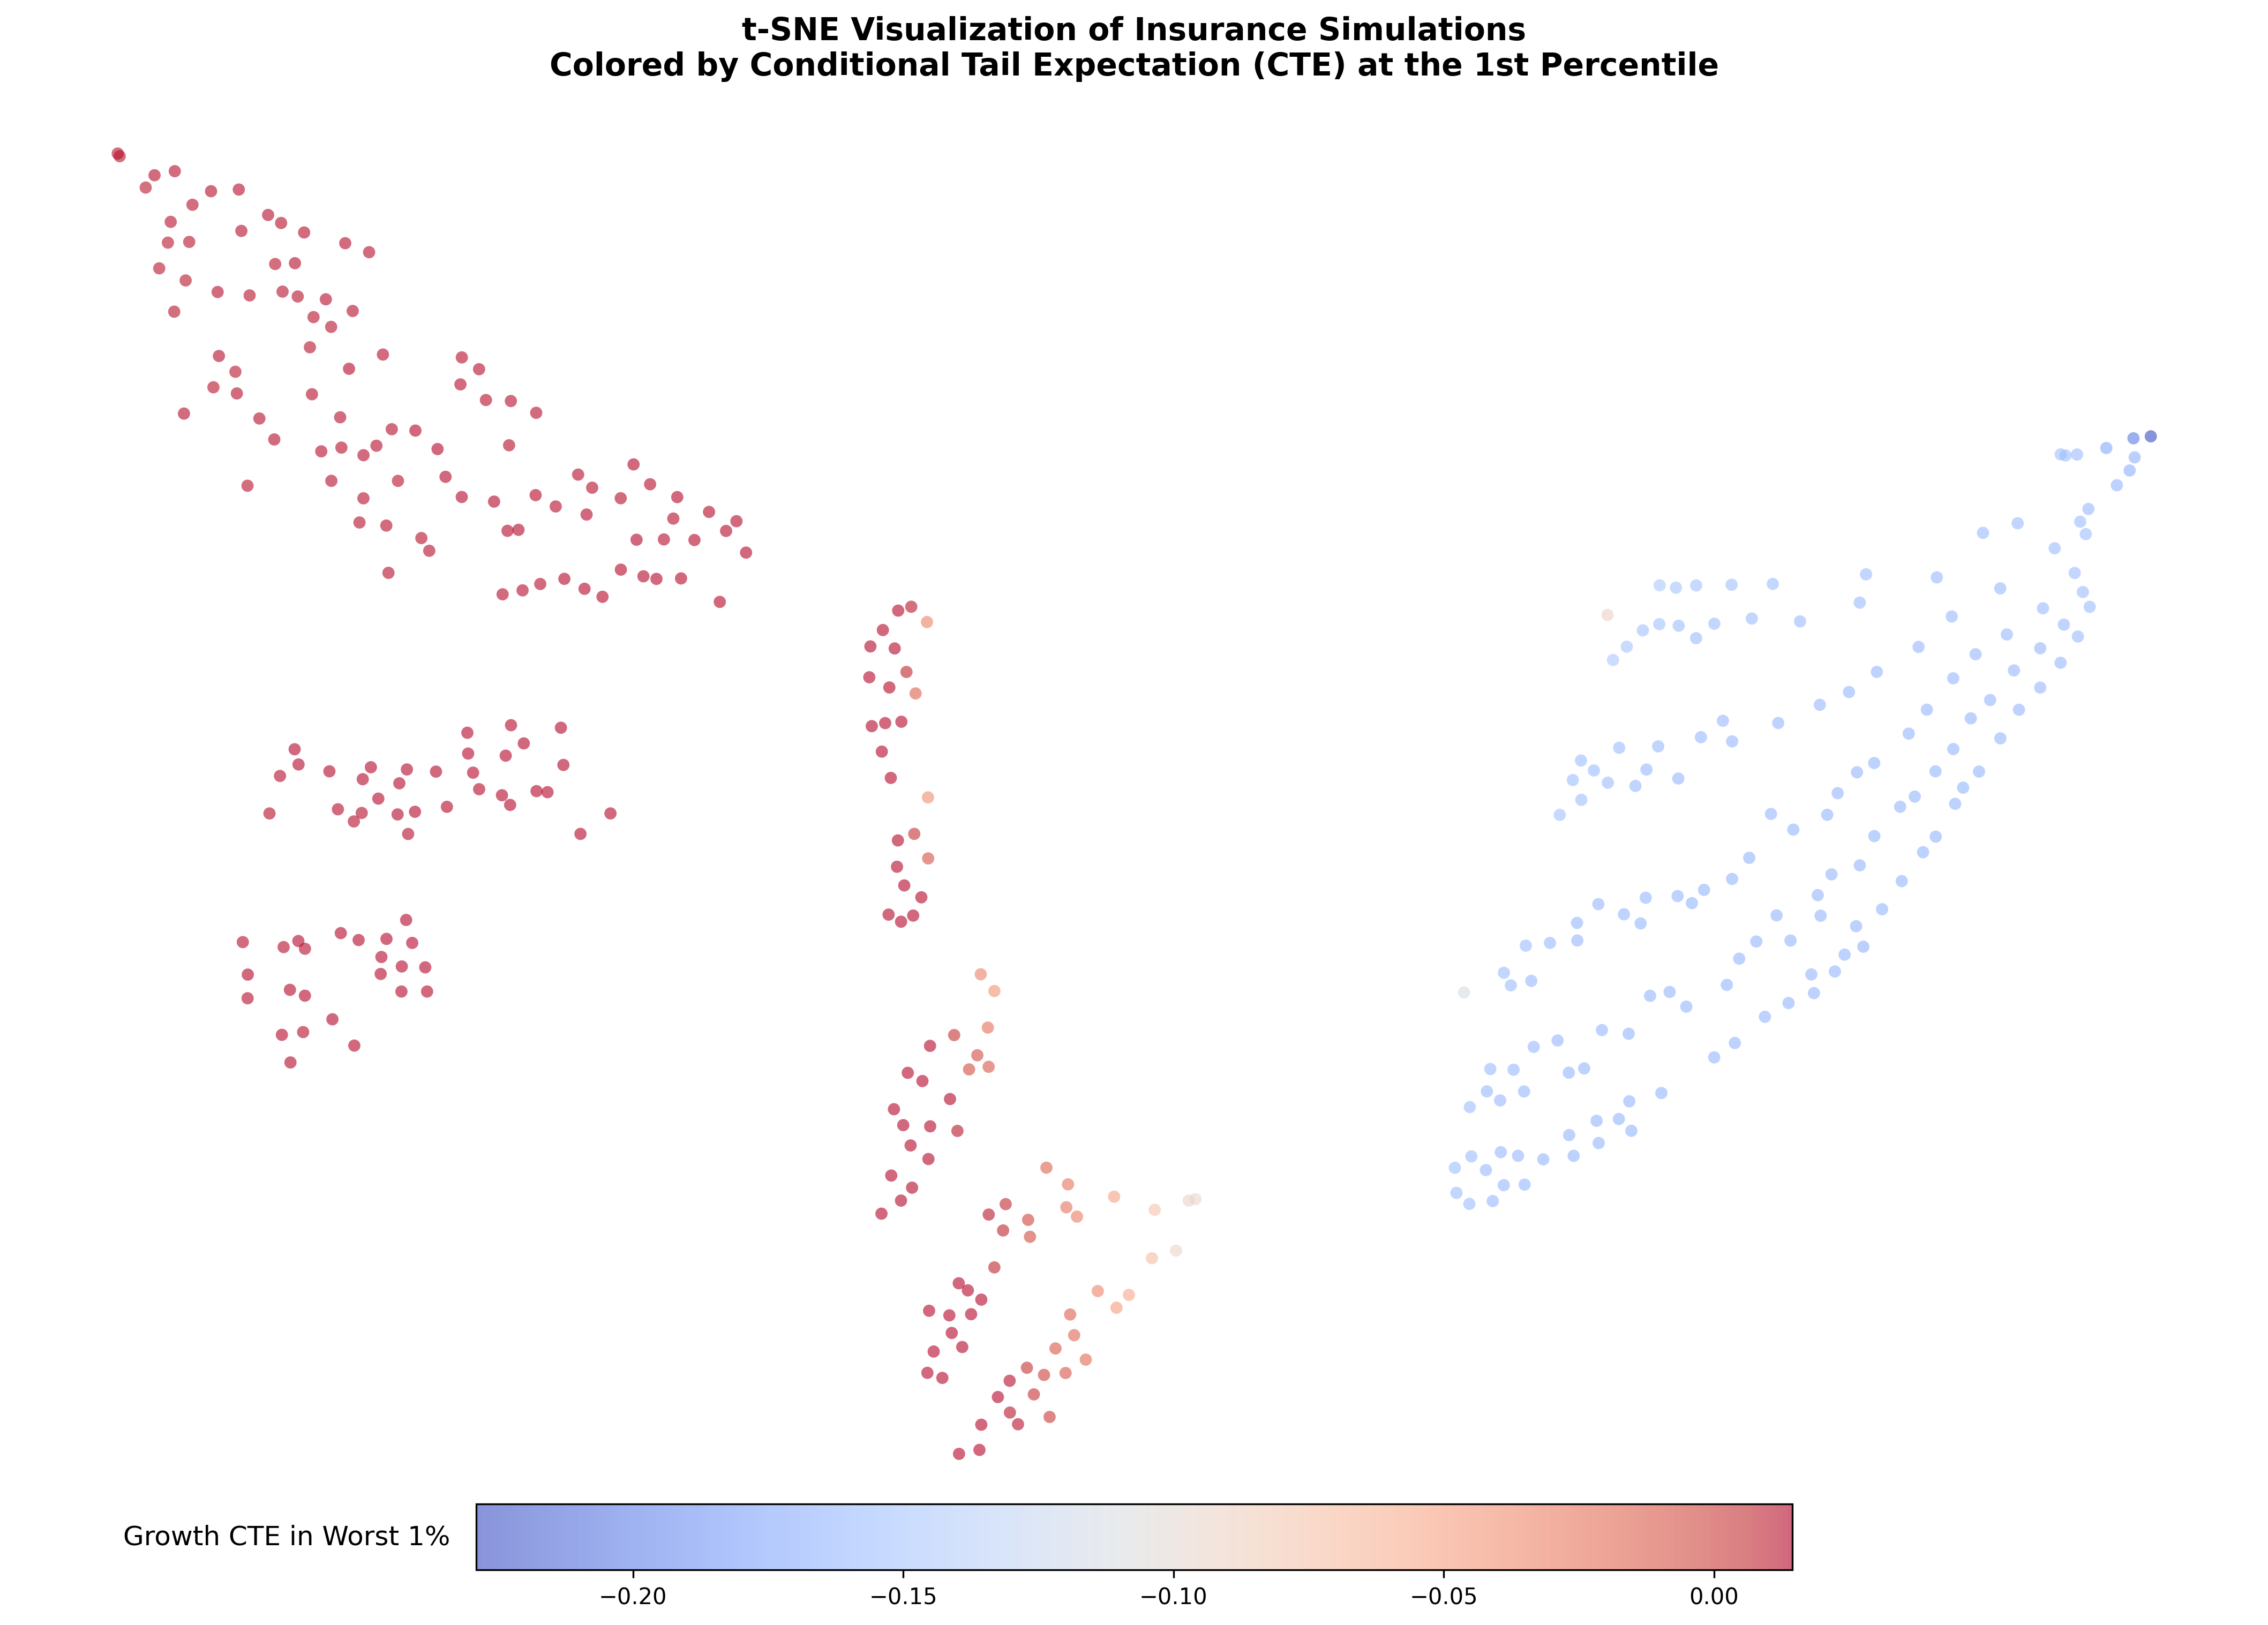


growth_rate_cte_q1.0 statistics:
  Min: -0.229016
  Max: 0.014475
  Mean: -0.059262
  Median: 0.011214


In [102]:
# Create visualization colored by growth_rate_cte_q1.0 (Conditional Tail Expectation)
print("Creating t-SNE visualization colored by growth_rate_cte_q1.0...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap (using diverging colormap for risk)
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_cte_q1.0'],
    cmap='coolwarm',  # Blue for negative (bad), red for positive (good)
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Growth CTE in Worst 1%', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Conditional Tail Expectation (CTE) at the 1st Percentile', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_cte_q1.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_cte_q1.0 statistics:")
print(f"  Min: {df['growth_rate_cte_q1.0'].min():.6f}")
print(f"  Max: {df['growth_rate_cte_q1.0'].max():.6f}")
print(f"  Mean: {df['growth_rate_cte_q1.0'].mean():.6f}")
print(f"  Median: {df['growth_rate_cte_q1.0'].median():.6f}")

Creating t-SNE visualization colored by risk_of_ruin_25...
Saved figure to cache\tsne_by_risk_of_ruin_25.png


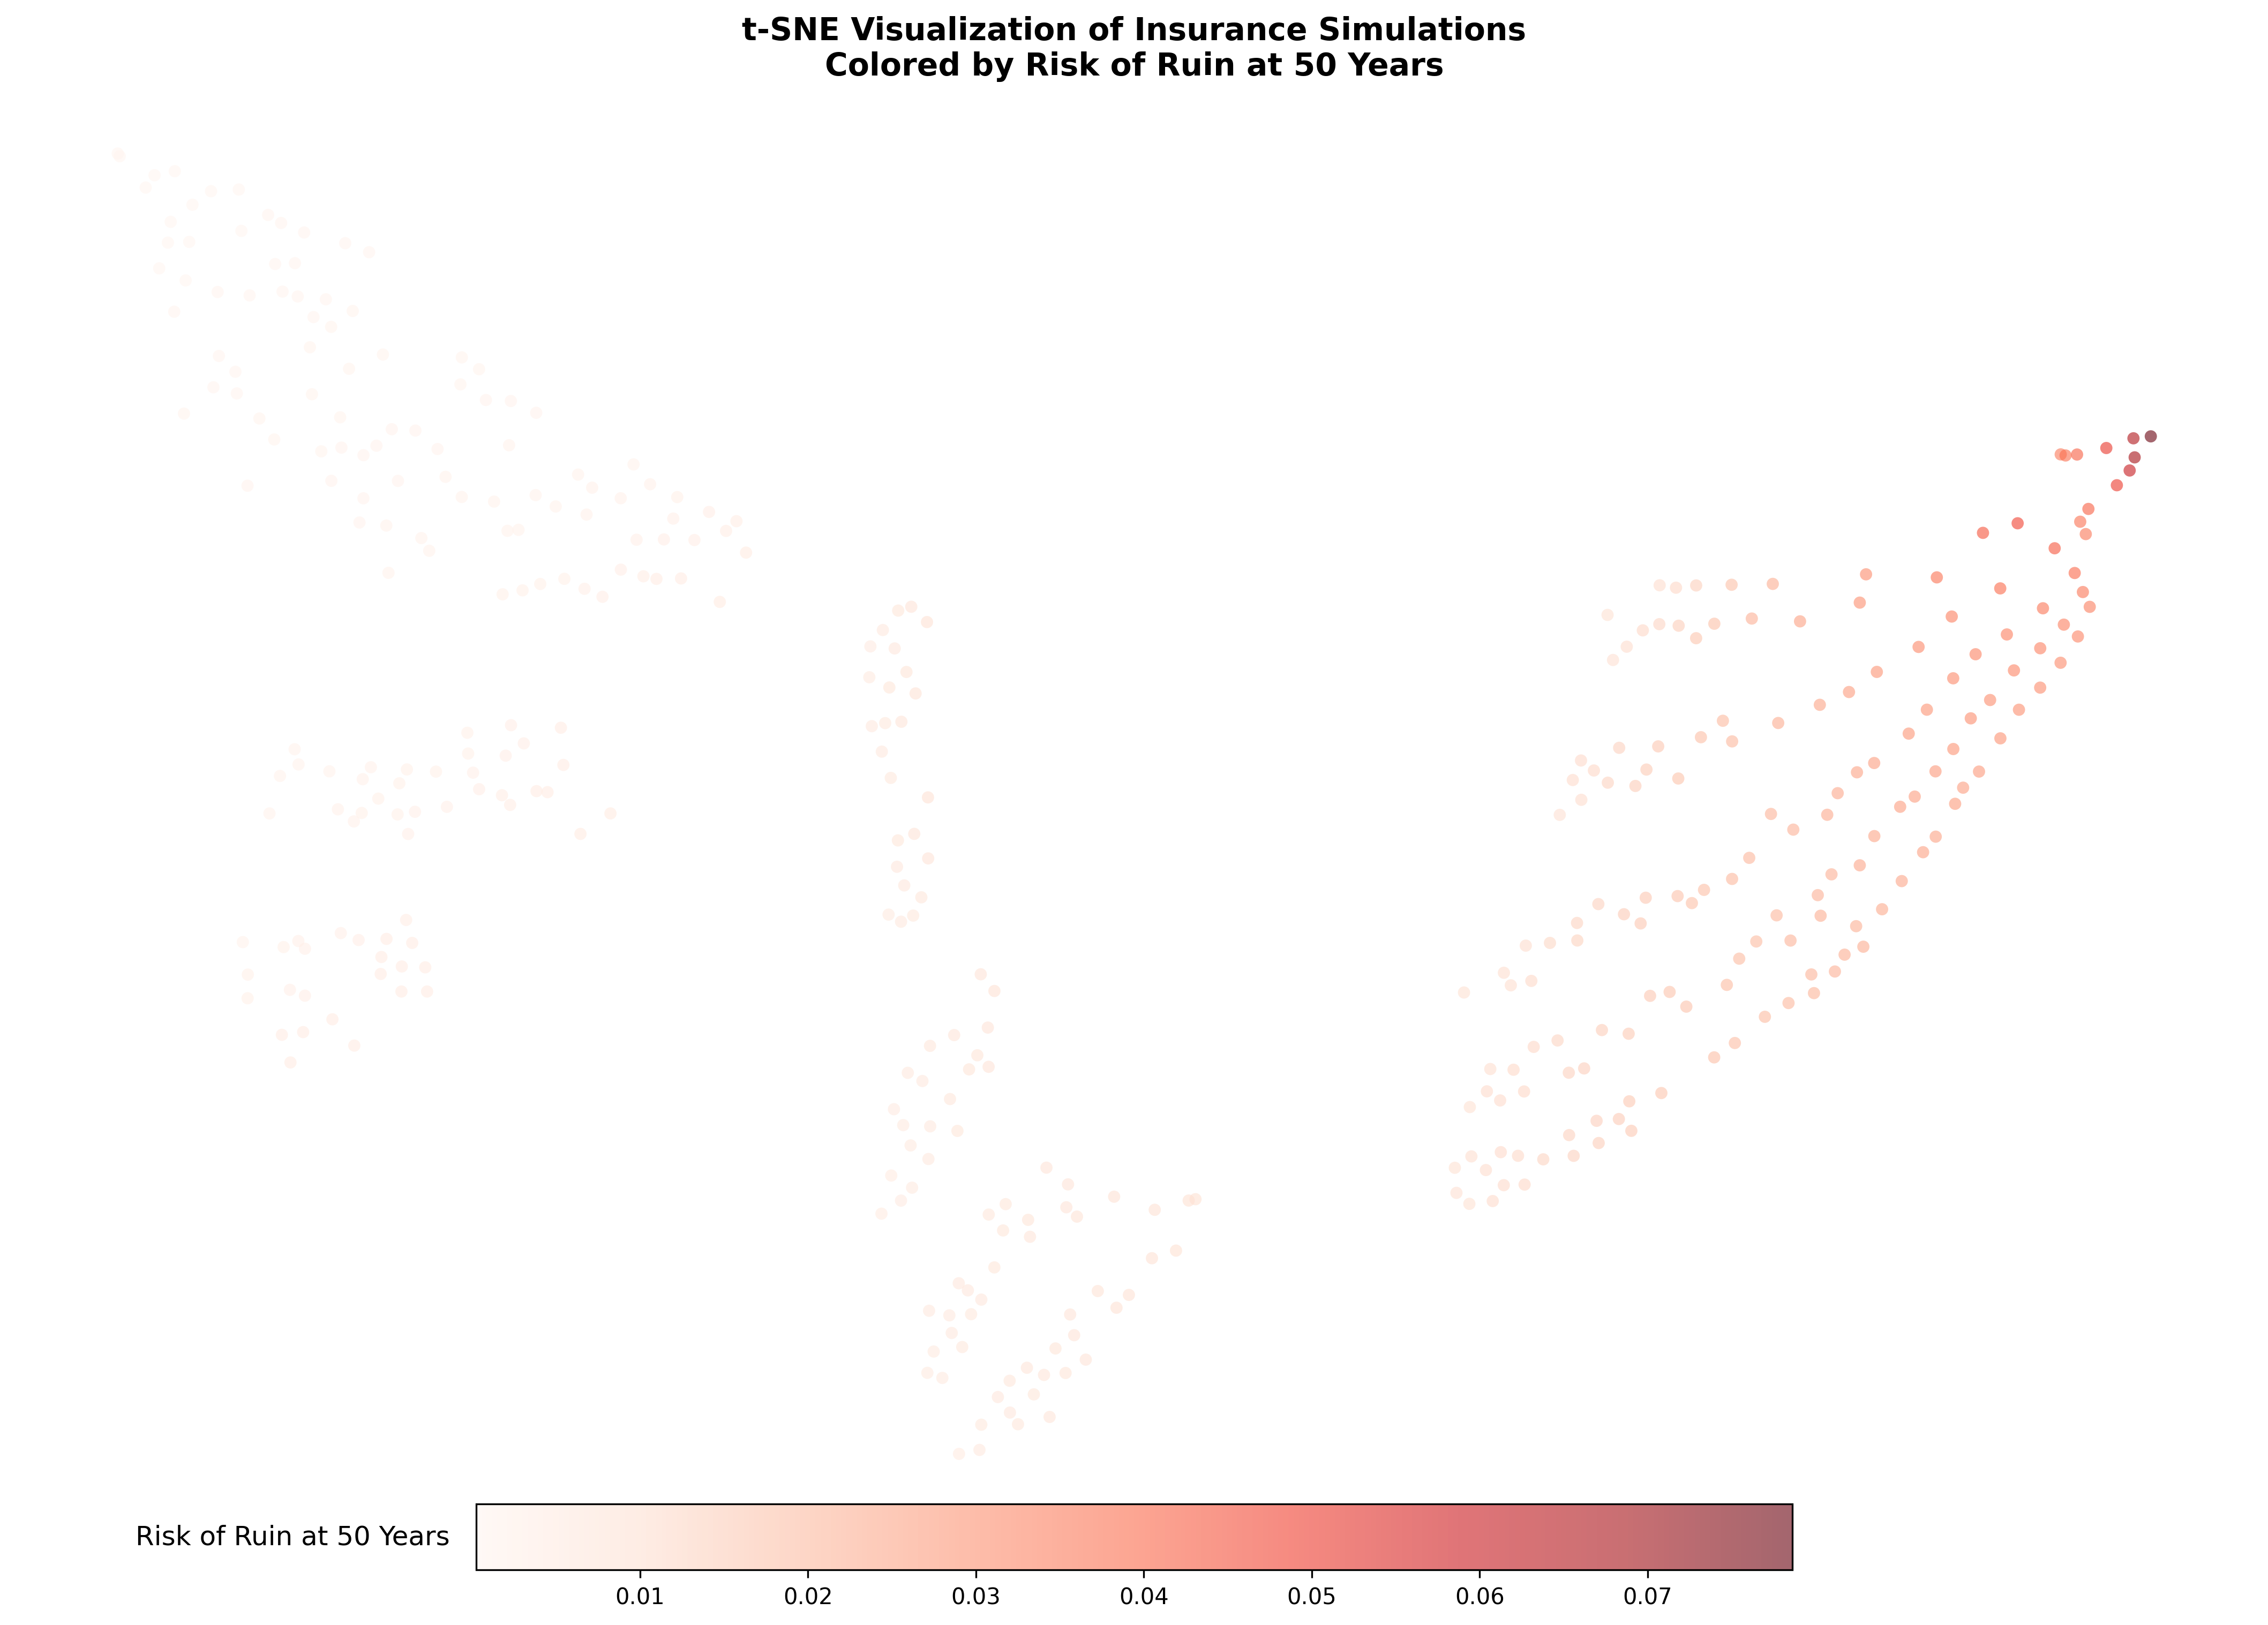


risk_of_ruin_25 statistics:
  Min: 0.000240
  Max: 0.078620
  Mean: 0.011598
  Median: 0.007350
  Non-zero count: 408/408


In [103]:
# Create visualization colored by risk_of_ruin_25 (Risk of Ruin at 50 years)
print("Creating t-SNE visualization colored by risk_of_ruin_25...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['risk_of_ruin_25'],
    cmap='Reds',  # White/light for low risk, red for high risk
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Risk of Ruin at 50 Years', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Risk of Ruin at 50 Years', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_risk_of_ruin_25.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\nrisk_of_ruin_25 statistics:")
print(f"  Min: {df['risk_of_ruin_25'].min():.6f}")
print(f"  Max: {df['risk_of_ruin_25'].max():.6f}")
print(f"  Mean: {df['risk_of_ruin_25'].mean():.6f}")
print(f"  Median: {df['risk_of_ruin_25'].median():.6f}")
print(f"  Non-zero count: {(df['risk_of_ruin_25'] > 0).sum()}/{len(df)}")

Creating t-SNE visualization colored by growth_rate_cv...
Saved figure to cache\tsne_by_growth_rate_cv.png


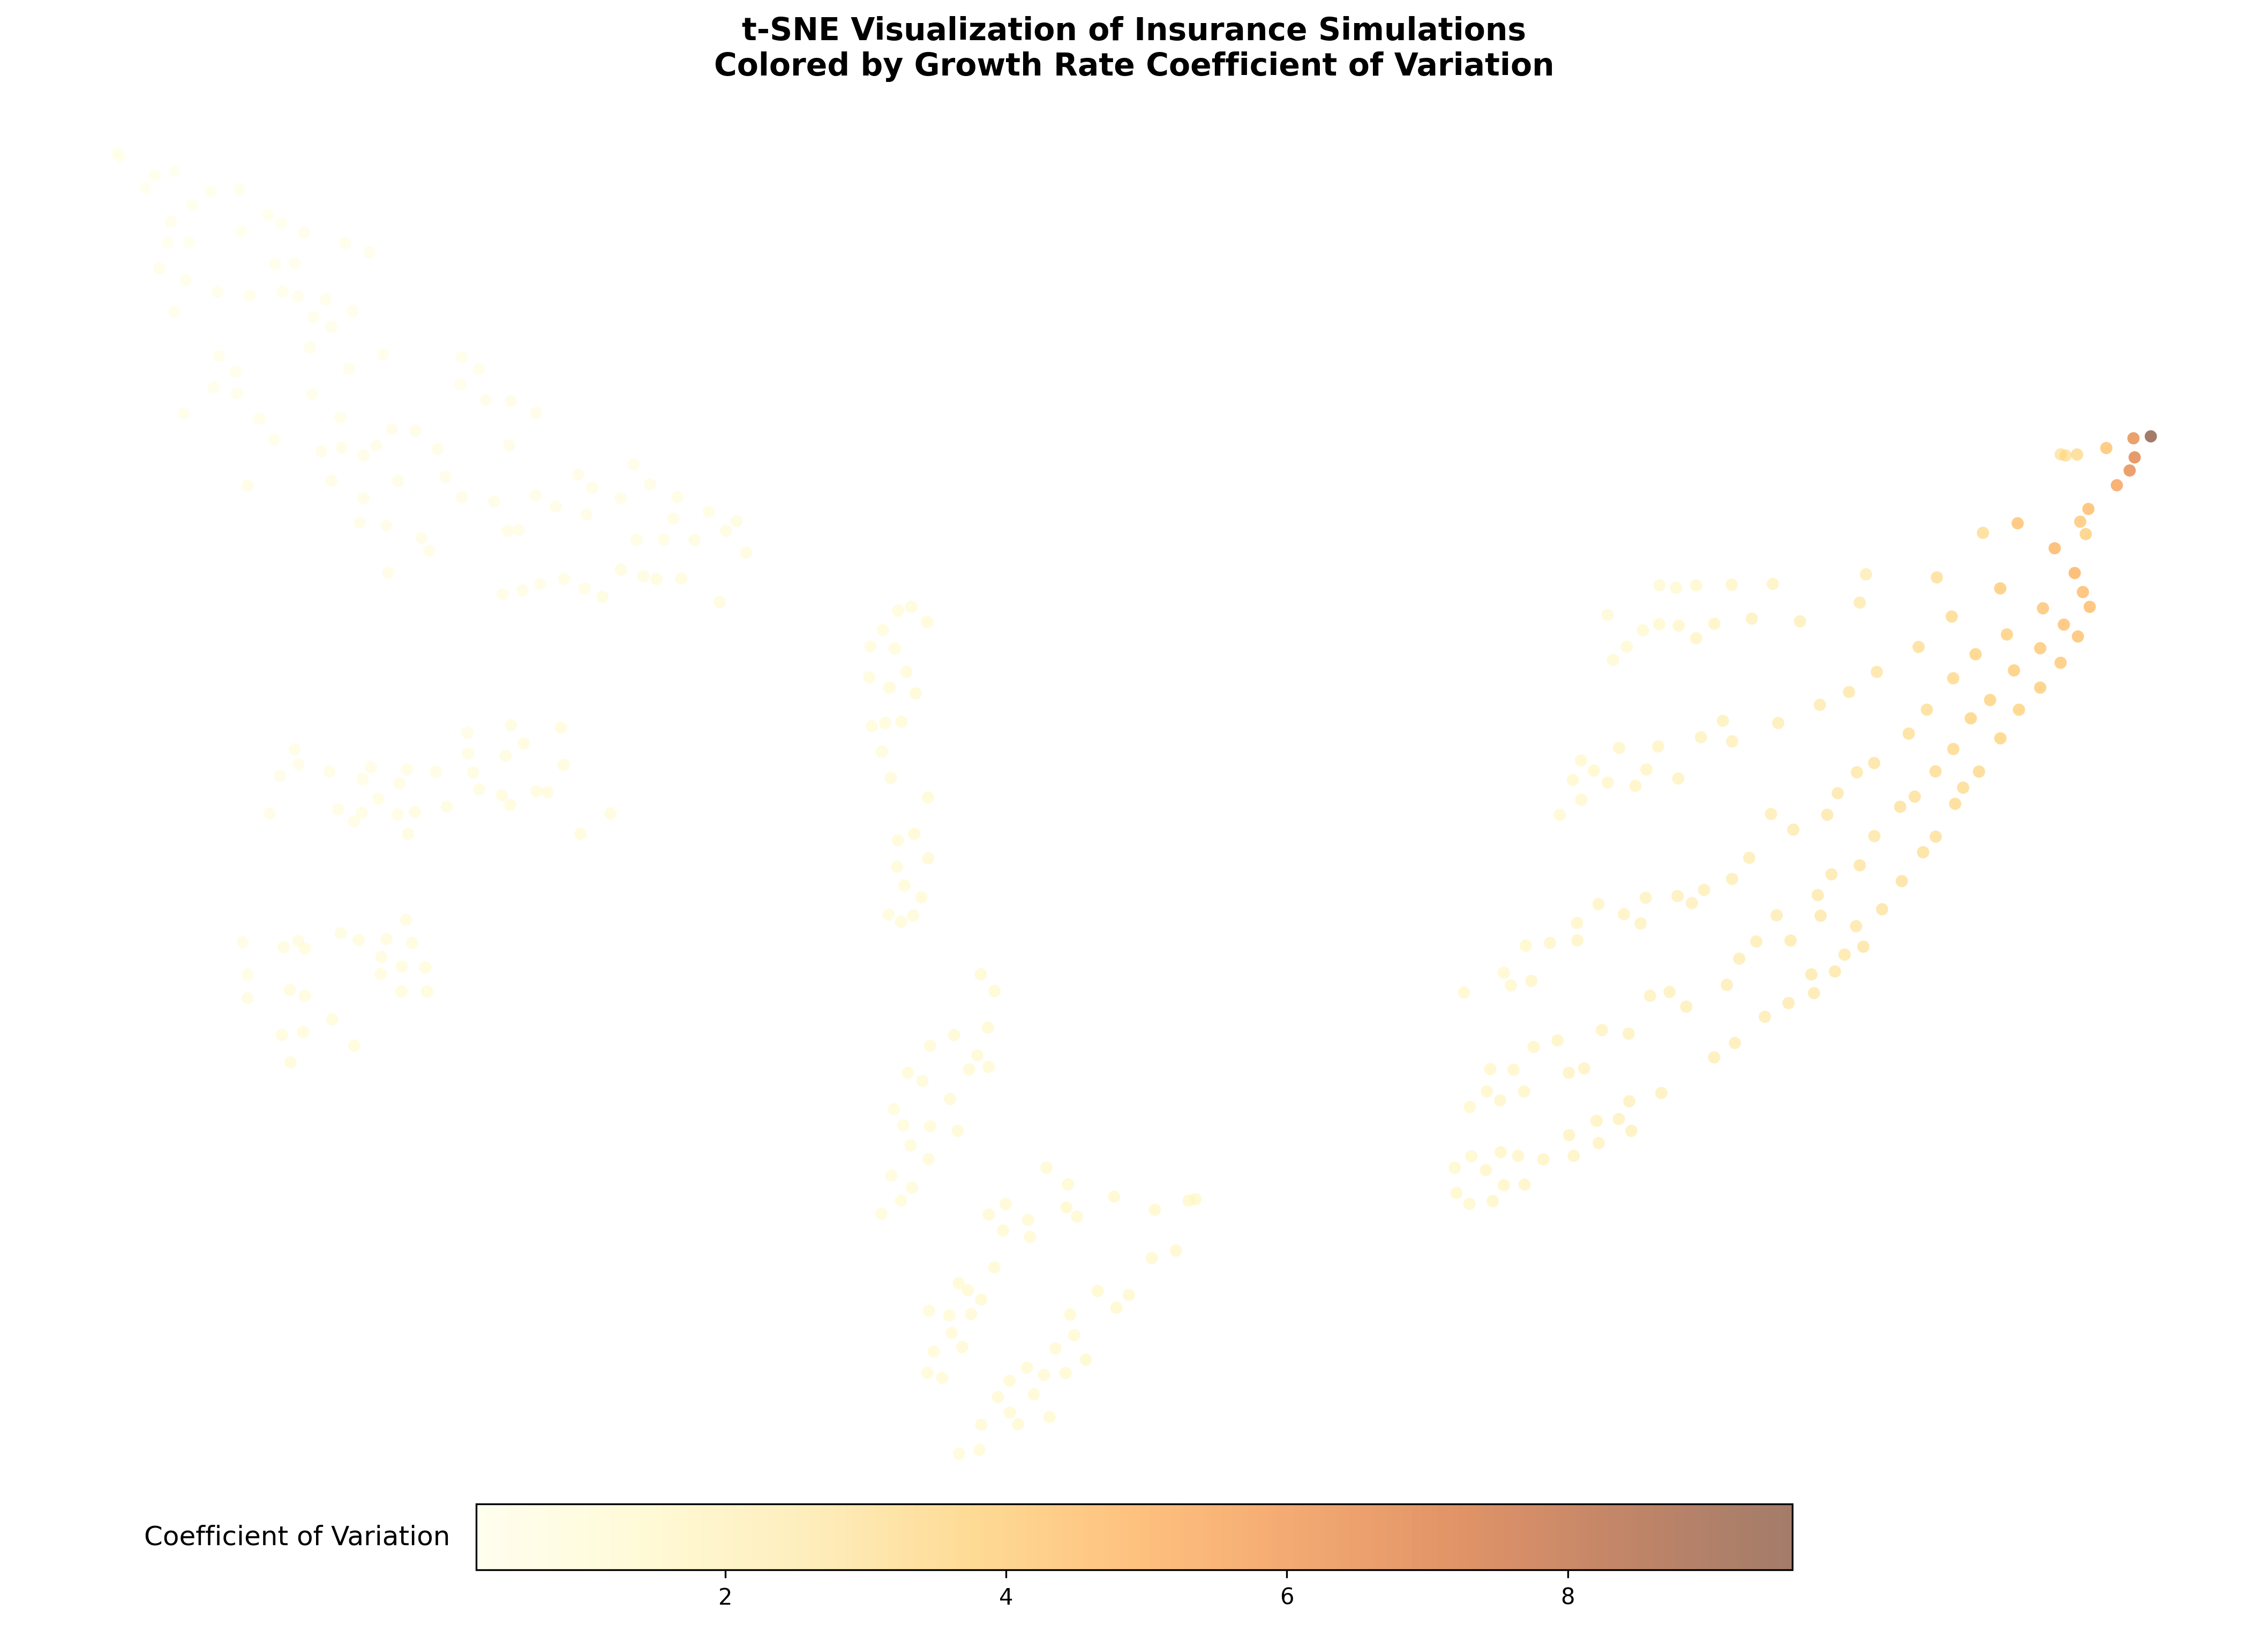


growth_rate_cv statistics:
  Min: 0.227056
  Max: 9.600253
  Mean: 1.535927
  Median: 1.222638
  Non-zero count: 408/408


In [104]:
# Create visualization colored by growth_rate_cv (Coefficient of Variation)
print("Creating t-SNE visualization colored by growth_rate_cv...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_cv'],
    cmap='YlOrBr',
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Coefficient of Variation', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Growth Rate Coefficient of Variation', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_cv.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_cv statistics:")
print(f"  Min: {df['growth_rate_cv'].min():.6f}")
print(f"  Max: {df['growth_rate_cv'].max():.6f}")
print(f"  Mean: {df['growth_rate_cv'].mean():.6f}")
print(f"  Median: {df['growth_rate_cv'].median():.6f}")
print(f"  Non-zero count: {(df['growth_rate_cv'] > 0).sum()}/{len(df)}")

Creating t-SNE visualization colored by growth_rate_kurtosis...
Saved figure to cache\tsne_by_growth_rate_kurtosis.png


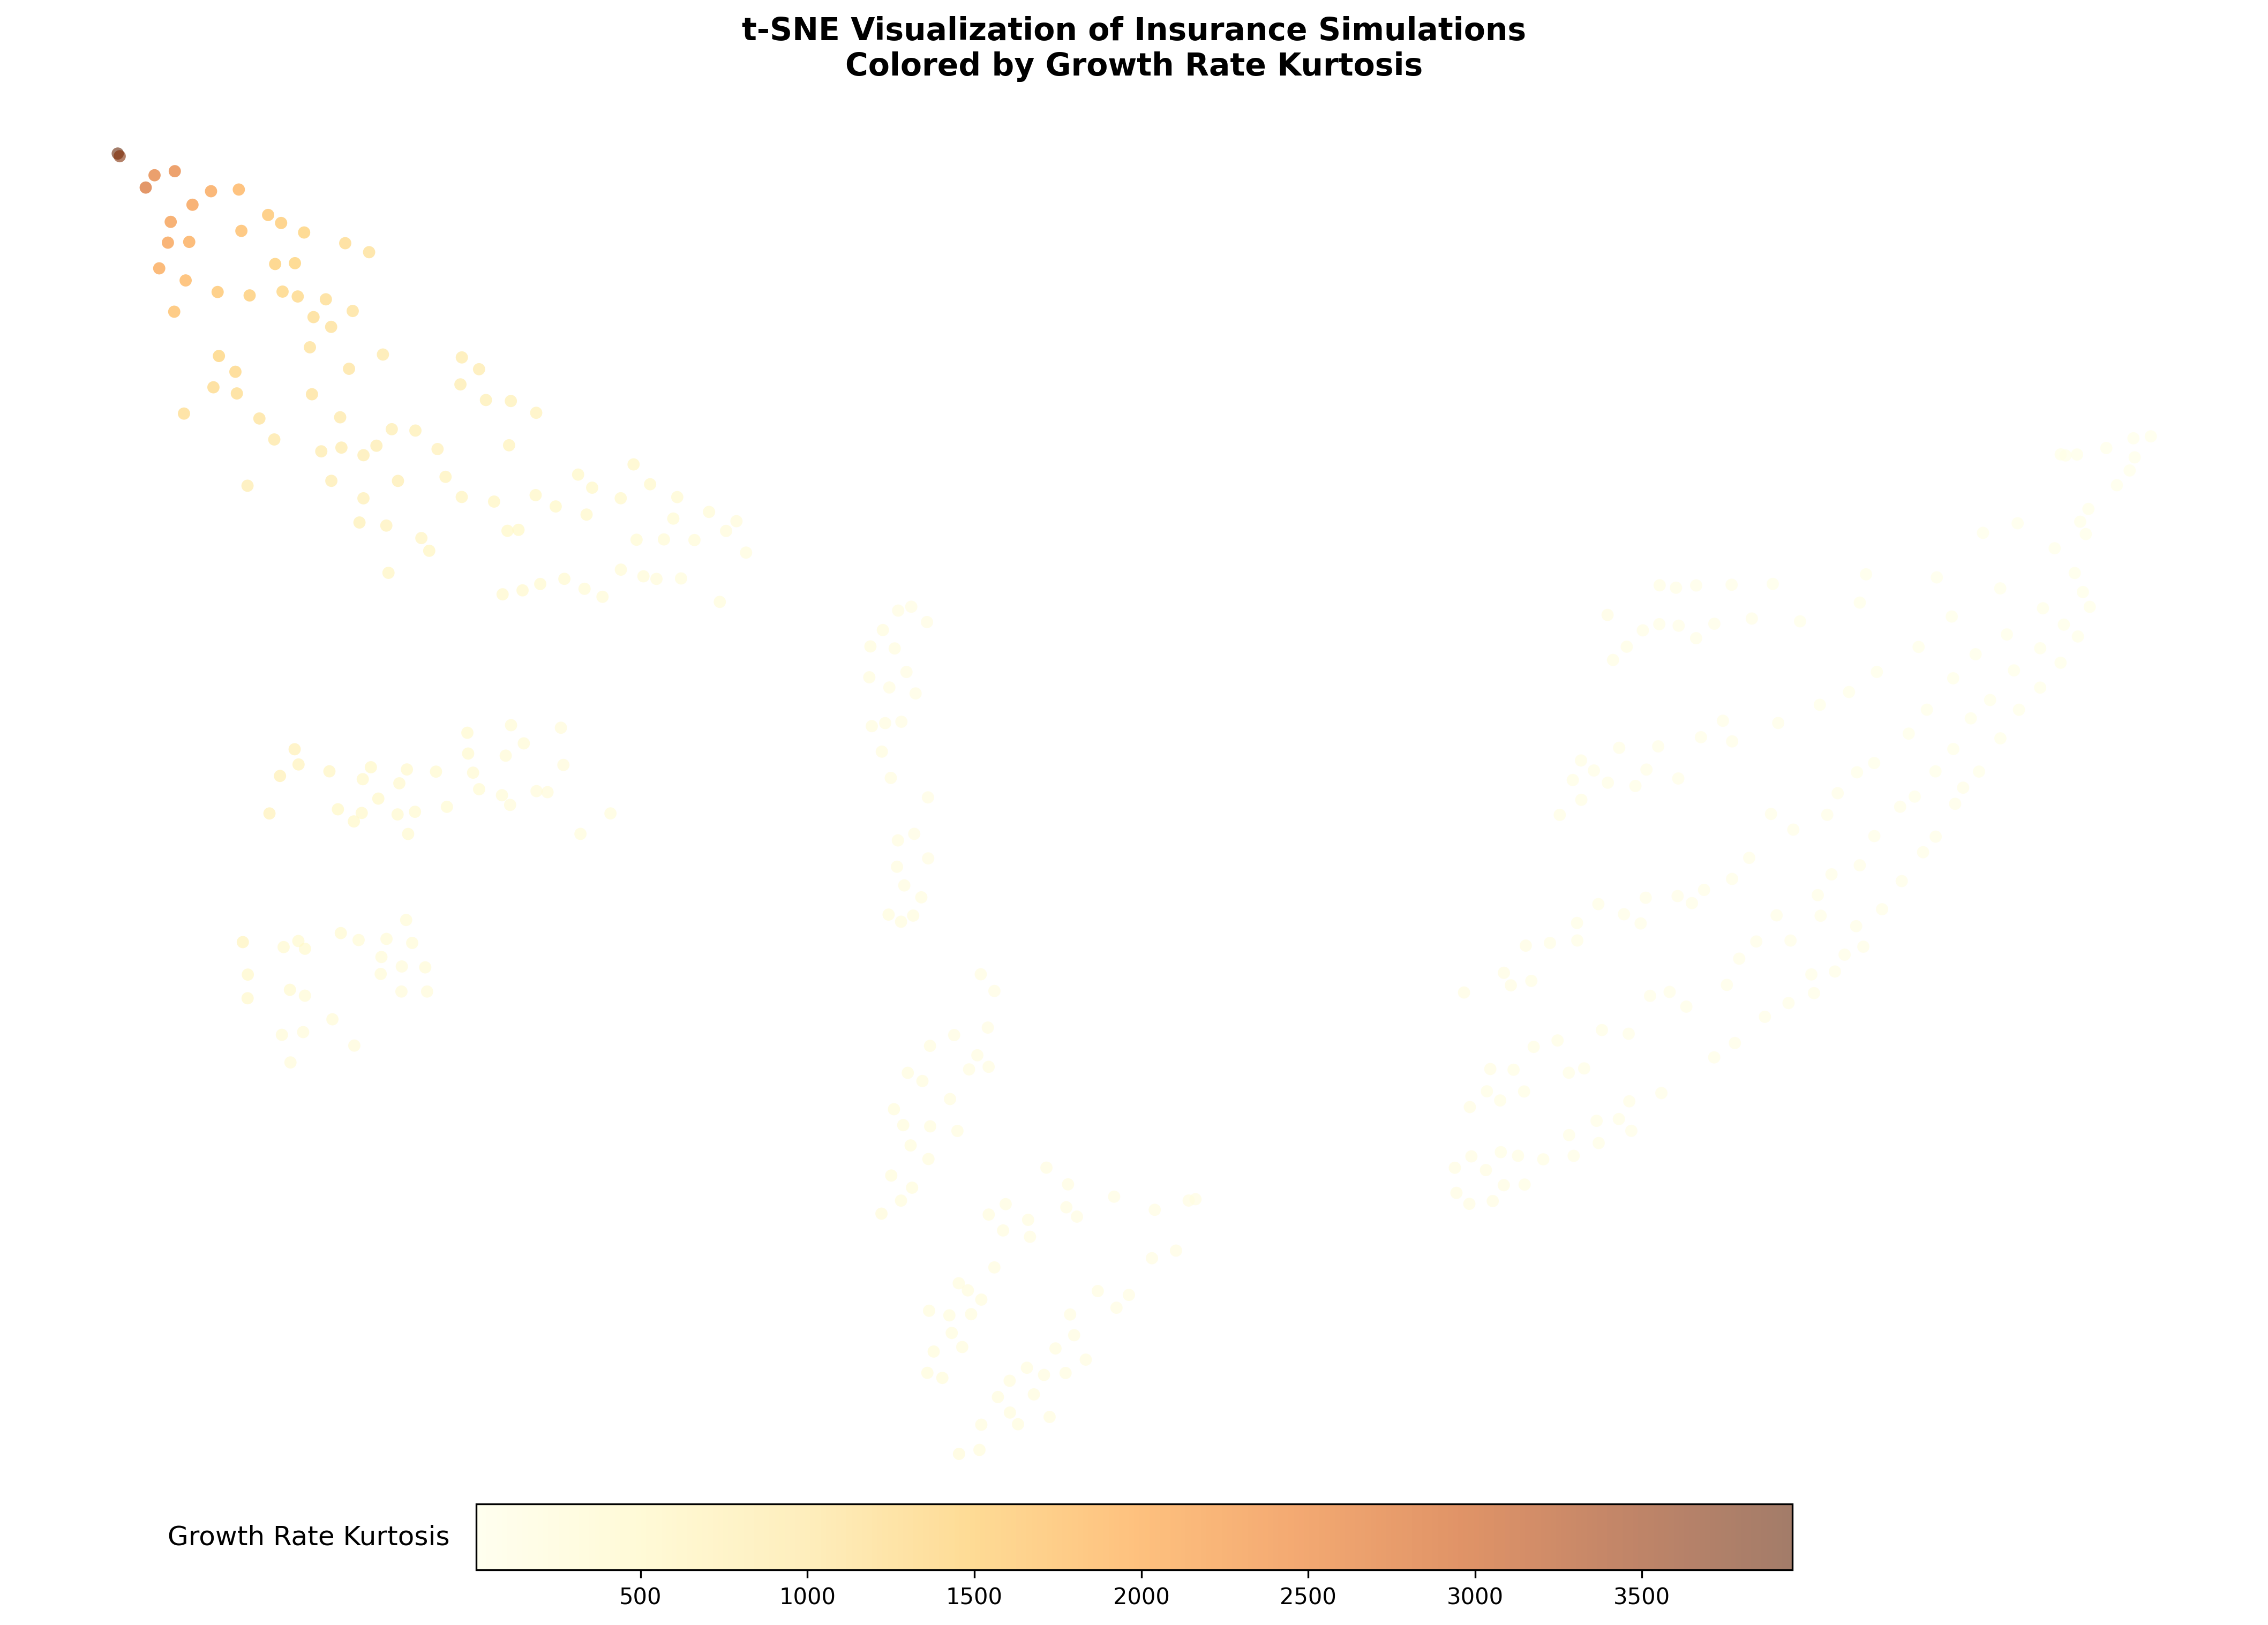


growth_rate_kurtosis statistics:
  Min: 7.821503
  Max: 3950.365325
  Mean: 361.160303
  Median: 154.417740
  Non-zero count: 408/408


In [105]:
# Create visualization colored by growth_rate_kurtosis (Kurtosis)
print("Creating t-SNE visualization colored by growth_rate_kurtosis...")

fig, ax = plt.subplots(figsize=(14, 10), dpi=300, constrained_layout=True)

# Create scatter plot with continuous colormap
scatter = ax.scatter(
    df['tsne_x'],
    df['tsne_y'],
    c=df['growth_rate_kurtosis'],
    cmap='YlOrBr',
    alpha=0.6,
    s=30,
    edgecolors='none'
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=-0.01, fraction=0.046)
cbar.ax.tick_params(axis='x', pad=4)
cbar.ax.set_xlabel('')
cbar.ax.text(-0.02, 0.5, 'Growth Rate Kurtosis', ha='right', va='center',
             transform=cbar.ax.transAxes, fontsize=12)

# ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
# ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Ensure the background grid is not drawn even if enabled later
ax.grid = lambda *args, **kwargs: None
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('t-SNE Visualization of Insurance Simulations\nColored by Growth Rate Kurtosis', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Save figure
output_file = cache_dir / "tsne_by_growth_rate_kurtosis.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_file}")

plt.show()

print(f"\ngrowth_rate_kurtosis statistics:")
print(f"  Min: {df['growth_rate_kurtosis'].min():.6f}")
print(f"  Max: {df['growth_rate_kurtosis'].max():.6f}")
print(f"  Mean: {df['growth_rate_kurtosis'].mean():.6f}")
print(f"  Median: {df['growth_rate_kurtosis'].median():.6f}")
print(f"  Non-zero count: {(df['growth_rate_kurtosis'] > 0).sum()}/{len(df)}")

In [106]:
# Summary of t-SNE analysis
print("=" * 70)
print("t-SNE ANALYSIS SUMMARY")
print("=" * 70)
print(f"\nDataset: {len(df)} insurance simulation configurations")
print(f"Features used: {len(all_features)} total")
print(f"  - Input parameters: {len(input_features)}")
print(f"  - Output metrics: {len(output_features)}")
print(f"\nt-SNE Parameters:")
print(f"  - Perplexity: 30")
print(f"  - Learning rate: 200")
print(f"  - Max iterations: 1000")
print(f"  - Random state: 42")
print(f"\nCached Data:")
print(f"  - t-SNE embedding: {tsne_cache_file}")
print(f"\nGenerated Visualizations (7 plots):")
print(f"  1. Categorical by X_Shape: cache/tsne_by_x_shape.png")
print(f"  2. Categorical by Pol_Lim: cache/tsne_by_pol_lim.png")
print(f"  3. Continuous by growth_rate_mean: cache/tsne_by_growth_rate_mean.png")
print(f"  4. Continuous by growth_rate_q50: cache/tsne_by_growth_rate_q50.png")
print(f"  5. Continuous by growth_rate_q5: cache/tsne_by_growth_rate_q5.png")
print(f"  6. Continuous by growth_rate_cte_q1.0: cache/tsne_by_growth_rate_cte_q1.png")
print(f"  7. Continuous by risk_of_ruin_50: cache/tsne_by_risk_of_ruin_50.png")
print("\nNote: To regenerate t-SNE with different parameters, delete the cache file.")
print("=" * 70)

t-SNE ANALYSIS SUMMARY

Dataset: 408 insurance simulation configurations
Features used: 34 total
  - Input parameters: 4
  - Output metrics: 30

t-SNE Parameters:
  - Perplexity: 30
  - Learning rate: 200
  - Max iterations: 1000
  - Random state: 42

Cached Data:
  - t-SNE embedding: cache\tsne_embedding.pkl

Generated Visualizations (7 plots):
  1. Categorical by X_Shape: cache/tsne_by_x_shape.png
  2. Categorical by Pol_Lim: cache/tsne_by_pol_lim.png
  3. Continuous by growth_rate_mean: cache/tsne_by_growth_rate_mean.png
  4. Continuous by growth_rate_q50: cache/tsne_by_growth_rate_q50.png
  5. Continuous by growth_rate_q5: cache/tsne_by_growth_rate_q5.png
  6. Continuous by growth_rate_cte_q1.0: cache/tsne_by_growth_rate_cte_q1.png
  7. Continuous by risk_of_ruin_50: cache/tsne_by_risk_of_ruin_50.png

Note: To regenerate t-SNE with different parameters, delete the cache file.


In [107]:
animation_source = [
    "cache/tsne_by_cap.png",
    "cache/tsne_by_pol_lim.png",
    "cache/tsne_by_growth_rate_mean.png",
    "cache/tsne_by_growth_rate_q50.png",
    "cache/tsne_by_growth_rate_q5.png",
    "cache/tsne_by_growth_rate_cte_q1.png",
    "cache/tsne_by_risk_of_ruin_25.png"]

In [108]:
from PIL import Image
from pathlib import Path

# Load all images
images = [Image.open(img_path) for img_path in animation_source]

# Save as animated GIF
output_path = Path("cache/tsne_animation.gif")
# Create the animation with two loops: fast then slow
fast_loop = images.copy()
slow_loop = images.copy()

# Create lists of images with their durations
frames = []
durations = []

# Fast loop (500ms per frame)
frames.extend(fast_loop)
durations.extend([750] * len(fast_loop))

# Slow loop (3000ms per frame)
frames.extend(slow_loop)
durations.extend([7500] * len(slow_loop))

# Save with variable frame durations
# Find the maximum dimensions
max_width = max(img.width for img in images)
max_height = max(img.height for img in images)

# Create new images with white background, aligned to the left
aligned_frames = []
for img in frames:
    # Create a new white image with max dimensions
    new_img = Image.new('RGBA', (max_width, max_height), (255, 255, 255, 255))
    # Paste the original image at the top-left (0, 0)
    new_img.paste(img, (0, 0))
    aligned_frames.append(new_img)

# Save with the aligned frames
aligned_frames[0].save(
    output_path,
    save_all=True,
    append_images=aligned_frames[1:],
    duration=durations,
    loop=0  # 0 means loop indefinitely
)

print(f"Animated GIF saved to {output_path}")
print(f"Total frames: {len(images)}")

FileNotFoundError: [Errno 2] No such file or directory: 'cache/tsne_by_cap.png'